# Project 3 : Designing an app for the public healthcare

***

<div style="text-align: justify"> The aim of this project is to design an app for public health. The agency <a href="https://www.santepubliquefrance.fr"> Santé publique France</a> has announced a call for proposals to find innovative ideas for applications related to food. This project will be the first step into the developement of an app idea. </div> <br>

<div style="text-align: justify"> The data are from the website Open Food Facts and can be downloaded following <a href="https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/parcours-data-scientist/P2/fr.openfoodfacts.org.products.csv.zip"> here</a>. Open Food Facts is collaborative food products database with contributors from all around the world. The project has been initiated by Stéphane Gigandet. A quick overall description of the features can be found <a href="https://world.openfoodfacts.org/data/data-fields.txt"> here</a> and these are separated into 4 sections : </div>

- The general information regarding the product : name, modification date, etc.
- A collection of tags : product's category, location, origin, etc.
- The ingredients of the products and their possible additives.
- Nutritional information: quantity in grams of a nutrient per 100 grams of the product.

<div style="text-align: justify"> Some features of the dataset will be more useful than others for the development of our application. Here is the list of features selected for our application. We will have to perform a cleaning step on these variables in order to extract a dataset ready for exploratory analysis. </div>

***

#### Data Content of fr.openfoodfacts.org.products.csv
<blockquote> 
<b>code :</b> Product barcode as it appears on the package (EAN-13, EAN-8 or other). <br>
<b>product_name :</b> Name of the product. <br>
<b>categories_fr :</b> Category of the product (eg: if it's a drink, its category is baverages <br>
<b>countries_fr :</b> Country where the product is sold. In our case, products should be sold in France only. <br>
<b>nutrition_grade_fr :</b> Nutri-Score rating from A to E. <br>
<b>energy_100g :</b> Energy, in kJ. <br>
<b>nutrition-score-fr_100g :</b> Nutri-Score rating associated from -15 to 40. <br>
<b>[nutrient]_100g :</b> Nutritional values that appear on the package, per 100g / 100 ml of product as sold. <br>
</blockquote>

***

Before diving in the cleaning process of the dataset, here is a quick overview of the notebook's contents.

***

#### Summary of the contents
* [Python's libraries](#Python-libraries)
* [Reading CSV's files and content overview](#Read-CSV-files-and-content-overview)
* [Dataset filtering depending on the country](#Dataset-filtering-depending-on-the-country)
* [Preliminary cleaning of the dataset](#Preliminary-cleaning-of-the-dataset)
* [Cleaning and data manipulation on the nutrients columns](#Cleaning-and-data-manipulation-on-the-nutrients-columns)
    * [Handling and cleaning of the outliers](#Handling-and-cleaning-of-the-outliers)
    * [Handling and cleaning of the abnormal values](#Handling-and-cleaning-of-the-abnormal-values)
    * [Handling and cleaning missing values](#Handling-and-cleaning-missing-values)
    * [Mecanism of the missing values](#Mecanism-of-the-missing-values)
    * [Comparison between MICE (Multiple Iterative Chained Equation) and KNNImputer](#Comparison-between-MICE-(Multiple-Iterative-Chained-Equation)-and-KNNImputer)
    * [Imputing missing values with KNNImputer](#Imputing-missing-values-with-KNNImputer)
    * [Imputing missing values with IterativeImputer](#Imputing-missing-values-with-IterativeImputer)
* [Join imputed numerical features and categorical features](#Join-imputed-numerical-features-and-categorical-features)
* [Categorical features imputation](#Categorical-features-imputation)
* [Saving cleaned dataset to csv file](#Saving-cleaned-dataset-to-csv-file)
    
***

<div style="text-align: justify"> Throughout the project, some functions have been created and developped to ease the work and to apply the DRY and Do One Thing principles. A docstring has been written for each of the function but here's a snippet of these functions :  </div>

- <b><a href='#disp_outliers'>disp_outliers()</a> </b>: displays a list of boxplots or kdeplots of the numerical features.
- <b><a href='#handle_outliers'>handle_outliers()</a> </b>: returns the input DataFrame df without the outliers.
- <b><a href='#correct_abn_vals'>correct_abn_vals()</a> </b>: returns the input DataFrame df without the abnormal values.
- <b><a href='#correct_abn_vals_aft_imp'>correct_abn_vals_aft_imp()</a> </b>: returns the input DataFrame df with correction performed after imputations.
- <b><a href='#nutri_to_grade'>nutri_to_grade()</a> </b>: returns the input DataFrame df after imputing the nutrition_grade_fr's values.

***

<div style="text-align: justify"> The 3rd project is divided into two notebooks. The first one will be used for cleaning the provided dataset and the second one will be used for exploratory analysis of the cleaned dataset. </div>

https://fr.openfoodfacts.org/guide-pour-les-producteurs

## Python libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import missingno as msno
import seaborn as sns
import random
import math
from sklearn.impute import KNNImputer
# explicitly require this experimental feature
from sklearn.experimental import enable_iterative_imputer  # noqa
# now you can import normally from sklearn.impute
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import MinMaxScaler
# set the style of the plots
plt.style.use('seaborn-darkgrid')

## Read CSV files and content overview

In [2]:
cols = ['code', 'product_name', 'categories_fr', 'countries_fr', 'nutrition_grade_fr', 'pnns_groups_1',
        'pnns_groups_2', 'energy_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g',
        'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g', 'sodium_100g', 'calcium_100g',
        'iron_100g', 'fruits-vegetables-nuts_100g', 'nutrition-score-fr_100g']
off_data = pd.read_csv('fr.openfoodfacts.org.products.csv', sep='\t', low_memory=False,
                                usecols=cols)
off_data.head()

,code,product_name,categories_fr,countries_fr,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,calcium_100g,iron_100g,fruits-vegetables-nuts_100g,nutrition-score-fr_100g
0,0000000003087,Farine de blé noir,NaN,France,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000004530,Banana Chips Sweetened (Whole),NaN,États-Unis,d,NaN,NaN,2243.0,28.57,28.57,64.29,14.29,3.6,3.57,0.00000,0.000,0.000,0.00129,NaN,14.0
2,0000000004559,Peanuts,NaN,États-Unis,b,NaN,NaN,1941.0,17.86,0.00,60.71,17.86,7.1,17.86,0.63500,0.250,0.071,0.00129,NaN,0.0
3,0000000016087,Organic Salted Nut Mix,NaN,États-Unis,d,NaN,NaN,2540.0,57.14,5.36,17.86,3.57,7.1,17.86,1.22428,0.482,0.143,0.00514,NaN,12.0
4,0000000016094,Organic Polenta,NaN,États-Unis,NaN,NaN,NaN,1552.0,1.43,NaN,77.14,NaN,5.7,8.57,NaN,NaN,NaN,NaN,NaN,NaN


## Dataset filtering depending on the country

<div style="text-align: justify"> For now, our application will be limited essentially for France users. Then, we could open up to enlarge and allow french-speakers countries and finally open up internationally. </div>

In [3]:
off_data = off_data.loc[off_data.countries_fr == 'France']
off_data.head()

,code,product_name,categories_fr,countries_fr,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,calcium_100g,iron_100g,fruits-vegetables-nuts_100g,nutrition-score-fr_100g
0,0000000003087,Farine de blé noir,NaN,France,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46,0000000024600,Filet de bœuf,Filet-de-boeuf,France,NaN,unknown,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48,0000000027205,NaN,NaN,France,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
136,0000000039259,Twix x2,NaN,France,NaN,unknown,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
182,0000005200016,lentilles vertes,"Aliments et boissons à base de végétaux,Alimen...",France,NaN,Cereals and potatoes,Legumes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
print(off_data.shape)
off_data.columns;

(94392, 20)


In [5]:
off_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94392 entries, 0 to 320770
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   code                         94392 non-null  object 
 1   product_name                 87398 non-null  object 
 2   categories_fr                58752 non-null  object 
 3   countries_fr                 94392 non-null  object 
 4   nutrition_grade_fr           58501 non-null  object 
 5   pnns_groups_1                61635 non-null  object 
 6   pnns_groups_2                63636 non-null  object 
 7   energy_100g                  61434 non-null  float64
 8   fat_100g                     44591 non-null  float64
 9   saturated-fat_100g           59390 non-null  float64
 10  carbohydrates_100g           44179 non-null  float64
 11  sugars_100g                  59488 non-null  float64
 12  fiber_100g                   43646 non-null  float64
 13  proteins_100g  

In [6]:
off_data.describe()

,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,calcium_100g,iron_100g,fruits-vegetables-nuts_100g,nutrition-score-fr_100g
count,6.143400e+04,44591.000000,59390.000000,44179.000000,59488.000000,43646.000000,61184.000000,59544.000000,59541.000000,1910.000000,915.000000,2890.000000,58501.000000
mean,1.168106e+03,13.278775,5.386003,27.305038,13.235246,2.522618,7.794483,1.161267,0.457213,0.341775,0.051252,31.338225,8.601477
std,1.316053e+04,16.985125,8.538552,27.307367,19.028753,4.633695,7.930606,4.291300,1.689468,1.871279,0.851378,32.120817,9.017877
min,0.000000e+00,0.000000,0.000000,0.000000,-0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-15.000000
25%,4.270000e+02,1.300000,0.300000,3.980000,1.000000,0.000000,1.800000,0.080000,0.031496,0.120000,0.002670,0.000000,1.000000
50%,1.028000e+03,6.800000,1.900000,14.000000,4.000000,1.300000,6.000000,0.570000,0.224409,0.135000,0.005800,22.000000,8.000000
75%,1.640000e+03,21.000000,7.300000,52.700000,17.000000,3.200000,11.000000,1.250000,0.492126,0.346800,0.008000,51.000000,15.000000
max,3.251373e+06,380.000000,210.000000,190.000000,105.000000,178.000000,100.000000,211.000000,83.000000,69.500000,25.000000,100.000000,40.000000


In [7]:
off_data.isna().sum()

code                               0
product_name                    6994
categories_fr                  35640
countries_fr                       0
nutrition_grade_fr             35891
pnns_groups_1                  32757
pnns_groups_2                  30756
energy_100g                    32958
fat_100g                       49801
saturated-fat_100g             35002
carbohydrates_100g             50213
sugars_100g                    34904
fiber_100g                     50746
proteins_100g                  33208
salt_100g                      34848
sodium_100g                    34851
calcium_100g                   92482
iron_100g                      93477
fruits-vegetables-nuts_100g    91502
nutrition-score-fr_100g        35891
dtype: int64

## Preliminary cleaning of the dataset

<div style="text-align: justify"> A preliminary cleaning is been performed on the dataset to clean all the rows that don't have any value on them. There are multiple ways to do this : </div>

- The first method is the most consistent : by using `.isna().sum(axis=1)` to sum up all the missing values through a row, another way to do it is using `.isnull().all(axis=1)`.
- The second method is to use the function `.dropna()` with the argument how='all and axis=0 to delete all the rows that don't have values.

In [8]:
# Retrieving all the columns that ends with _100g
col_100g = [i for i in off_data.columns if i.endswith('_100g')]
print('Length of col_100g : {}'.format(len(col_100g)))

# Compute the number of missing values per row
off_data['Missing values per row'] = off_data.loc[:,col_100g].isna().sum(axis=1)
off_data.sort_values(by='Missing values per row', ascending=False).head()

# Easier way to compute if all the elements in each row and column are missing values
#off_data['Missing values per row'] = off_data.loc[:,col_100g].isnull().all(axis=1)

Length of col_100g : 13


,code,product_name,categories_fr,countries_fr,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,energy_100g,fat_100g,saturated-fat_100g,...,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,calcium_100g,iron_100g,fruits-vegetables-nuts_100g,nutrition-score-fr_100g,Missing values per row
0,0000000003087,Farine de blé noir,NaN,France,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13
231791,3417960023159,Cannelle moulue,NaN,France,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13
231793,3417960023173,Curry,"Aliments et boissons à base de végétaux,Alimen...",France,NaN,unknown,unknown,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13
231794,3417960023579,Thé Noir,"Aliments et boissons à base de végétaux,Boisso...",France,NaN,Beverages,Non-sugared beverages,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13
231795,3417960023814,Quatre baies,"Aliments et boissons à base de végétaux,Alimen...",France,NaN,unknown,unknown,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13


In [9]:
# Dropping all rows that don't have any values, generally : col missing values per row = len(col_100g)
cond = off_data[off_data['Missing values per row'] >= len(col_100g)]
off_data.drop(cond.index, inplace=True)

In [10]:
off_data.reset_index(drop=True, inplace=True);

In [11]:
off_data.isna().sum()

code                               0
product_name                     321
categories_fr                  16578
countries_fr                       0
nutrition_grade_fr              3700
pnns_groups_1                  13871
pnns_groups_2                  13745
energy_100g                      767
fat_100g                       17610
saturated-fat_100g              2811
carbohydrates_100g             18022
sugars_100g                     2713
fiber_100g                     18555
proteins_100g                   1017
salt_100g                       2657
sodium_100g                     2660
calcium_100g                   60291
iron_100g                      61286
fruits-vegetables-nuts_100g    59311
nutrition-score-fr_100g         3700
Missing values per row             0
dtype: int64

In [12]:
print(off_data.shape)
off_data.sort_values(by='Missing values per row', ascending=False).head()

(62201, 21)


,code,product_name,categories_fr,countries_fr,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,energy_100g,fat_100g,saturated-fat_100g,...,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,calcium_100g,iron_100g,fruits-vegetables-nuts_100g,nutrition-score-fr_100g,Missing values per row
35657,3441260039602,"Esprit des Marées - Pomme, Poire, Caramel au B...","Produits à tartiner,Petit-déjeuners,Produits à...",France,NaN,Sugary snacks,Sweets,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,74.0,NaN,12
521,0217911042115,tomme à l'ail,"Produits laitiers,Fromages,Produits de montagn...",France,NaN,Milk and dairy products,Cheese,NaN,28.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12
33853,3384430011001,Confiture de framboises épépinées,"Aliments et boissons à base de végétaux,Alimen...",France,NaN,Sugary snacks,Sweets,NaN,NaN,NaN,...,62.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12
49993,3770001823410,Stevia en poudre,"Aliments et boissons à base de végétaux,Alimen...",France,NaN,unknown,unknown,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12
49989,3770001691107,"Camembert du Boulonnais au lait cru, moulé à l...","Produits laitiers,Fromages,Fromages de vache,F...",France,NaN,Milk and dairy products,Cheese,NaN,22.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12


In [13]:
# Dropping the row 'Missing values per row'
off_data.drop(columns=['Missing values per row'], inplace=True)
off_data.head()

,code,product_name,categories_fr,countries_fr,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,calcium_100g,iron_100g,fruits-vegetables-nuts_100g,nutrition-score-fr_100g
0,0000010187319,Mini Confettis,NaN,France,d,NaN,NaN,1753.0,NaN,0.8,NaN,87.7,0.9,0.6,0.0100,0.003937,NaN,NaN,NaN,14.0
1,0000010207260,Praliné Amande Et Noisette,NaN,France,d,NaN,NaN,2406.0,NaN,2.9,NaN,50.3,3.9,9.5,0.0030,0.001181,NaN,NaN,NaN,14.0
2,0000040608754,"Pepsi, Nouveau goût !","Boissons,Boissons gazeuses,Sodas,Sodas au cola...",France,e,Beverages,Sweetened beverages,177.0,0.0,0.0,10.4,10.4,0.0,0.0,0.0254,0.010000,NaN,NaN,NaN,13.0
3,0000069161025,Tarte Poireaux Et Lardons,NaN,France,d,NaN,NaN,1079.0,NaN,11.0,NaN,1.0,1.4,7.5,0.8000,0.314961,NaN,NaN,NaN,15.0
4,0000087177756,7Up,"Aliments et boissons à base de végétaux,Boisso...",France,e,Beverages,Sweetened beverages,177.0,0.0,0.0,10.4,10.4,NaN,0.0,0.1000,0.039370,NaN,NaN,NaN,13.0


The preliminary cleaning allowed us to remove all the missing values from `code` column. We can now start cleaning the other features.

## Cleaning and data manipulation on the nutrients columns

<div style="text-align: justify"> The first idea that came up coherent to me regarding the missing values on the nutrient columns is that if there are missing values it's perhaps there are none of these nutrients in the product. Indeed, the product's label only shows the nutrients that are presents and so we could ask ourself if we can only impute by 0 all the nutrient features that have missing values. </div> <br>

<div style="text-align: justify"> By replacing missing values by 0 could lead to an unexpected bias on our futures feature analyses. Indeed, imputing missing values by 0, the global mean of a nutrient can be affected and so it can be lower than expected whereas if we keep missing values, there is a risk that we overestimate the average of a nutrient. </div> <br>

<div style="text-align: justify"> To conclude, imputing missing values with 0 decreases sentivity in multivariate analysis while if we choose to leave the cells empty, we will have to review the consistency of the variables. Those are the reasons why we need to carry and handle properly the missing values. </div> <br>

<div style="text-align: justify"> Before handling missing values, we should take care of the outliers. </div>

### <font color='gray'>Handling and cleaning of the outliers</font>

<div style="text-align: justify"> There are two commun ways to detect outliers : </div>

- If the distribution is normal (also known as Gaussian's distribution), we can use the standard deviation method (which is usually the easiest); everything that is considered as > 3$\sigma$ is considered as outliers. Then we can apply a KDE plot at the end.
- If the distribution is skewed, we can use the interquartile method which is all values below (Q1 - 1.5 * IQR), are considered as minimum outliers while all values that are above (Q3 + 1.5 * IRQ), are considered as maximum outliers. </br>

<div style="text-align: justify"> Then, to handle outliers, there are two techniques that can be used : the trimming and the capping. </div>

- The trimming is the method of cutting off or getting rid of the outliers at the end of the dataset. This is easier than all the other methods.
- The capping is setting a limit for the feature and set the value of all the outliers exceeding the limit to the value of the limit.

<div style="text-align: justify"> NB : Percentile method is used to determine outliers for normal AND skewed distributions. Once you detect these outliers you can use either trimming or capping to get rid of them. </div>

In [14]:
# Displaying all the infos of numerical features
off_data.describe()

,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,calcium_100g,iron_100g,fruits-vegetables-nuts_100g,nutrition-score-fr_100g
count,6.143400e+04,44591.000000,59390.000000,44179.000000,59488.000000,43646.000000,61184.000000,59544.000000,59541.000000,1910.000000,915.000000,2890.000000,58501.000000
mean,1.168106e+03,13.278775,5.386003,27.305038,13.235246,2.522618,7.794483,1.161267,0.457213,0.341775,0.051252,31.338225,8.601477
std,1.316053e+04,16.985125,8.538552,27.307367,19.028753,4.633695,7.930606,4.291300,1.689468,1.871279,0.851378,32.120817,9.017877
min,0.000000e+00,0.000000,0.000000,0.000000,-0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-15.000000
25%,4.270000e+02,1.300000,0.300000,3.980000,1.000000,0.000000,1.800000,0.080000,0.031496,0.120000,0.002670,0.000000,1.000000
50%,1.028000e+03,6.800000,1.900000,14.000000,4.000000,1.300000,6.000000,0.570000,0.224409,0.135000,0.005800,22.000000,8.000000
75%,1.640000e+03,21.000000,7.300000,52.700000,17.000000,3.200000,11.000000,1.250000,0.492126,0.346800,0.008000,51.000000,15.000000
max,3.251373e+06,380.000000,210.000000,190.000000,105.000000,178.000000,100.000000,211.000000,83.000000,69.500000,25.000000,100.000000,40.000000


<a id='disp_outliers'></a>
<div style="text-align: justify"> We create a function that allows us to display boxplots or their associated distribution to analyze outliers. </div>

In [15]:
def disp_outliers(df, plot) :
    """disp_outliers display the boxplots or the kdeplots of all the numerical features of the DataFrame df.
    
    Parameters:
    df (DataFrame): a DataFrame
    plot (string):  'boxplot' or 'kdeplot'
    
    """
    
    # Initializing figure and axes
    # Calling the col_100g global variable
    fig, ax = plt.subplots(math.ceil(len(col_100g)/4), 4, figsize=(14,16))
    
    i = 0; j = 0;

    for col in df[col_100g]:
        if (plot == 'boxplot') :
            if i < 4:
                sns.boxplot(data = df, y=col, ax=ax[j,i])
                ax[j,i].set_title(col)
                i+=1
            else:
                i=0
                j+=1
                sns.boxplot(data = df, y=col, ax=ax[j,i])
                ax[j,i].set_title(col)
                i+=1
                
            fig.suptitle('Boxplot of each nutrient to detect the potential outliers', y=1)
            
        else :
            if i < 4:
                sns.kdeplot(data = df, x=col, ax=ax[j,i])
                ax[j,i].set_title(col)
                i+=1
            else:
                i=0
                j+=1
                sns.kdeplot(data = df, x=col, ax=ax[j,i])
                ax[j,i].set_title(col)
                i+=1
                
            fig.suptitle('Distribution of each nutrient to detect the potential outliers', y=1)
    
    plt.tight_layout()
    plt.show()

We call the function `disp_outliers()` to display the boxplots to visualize the outliers of each numerical feature.

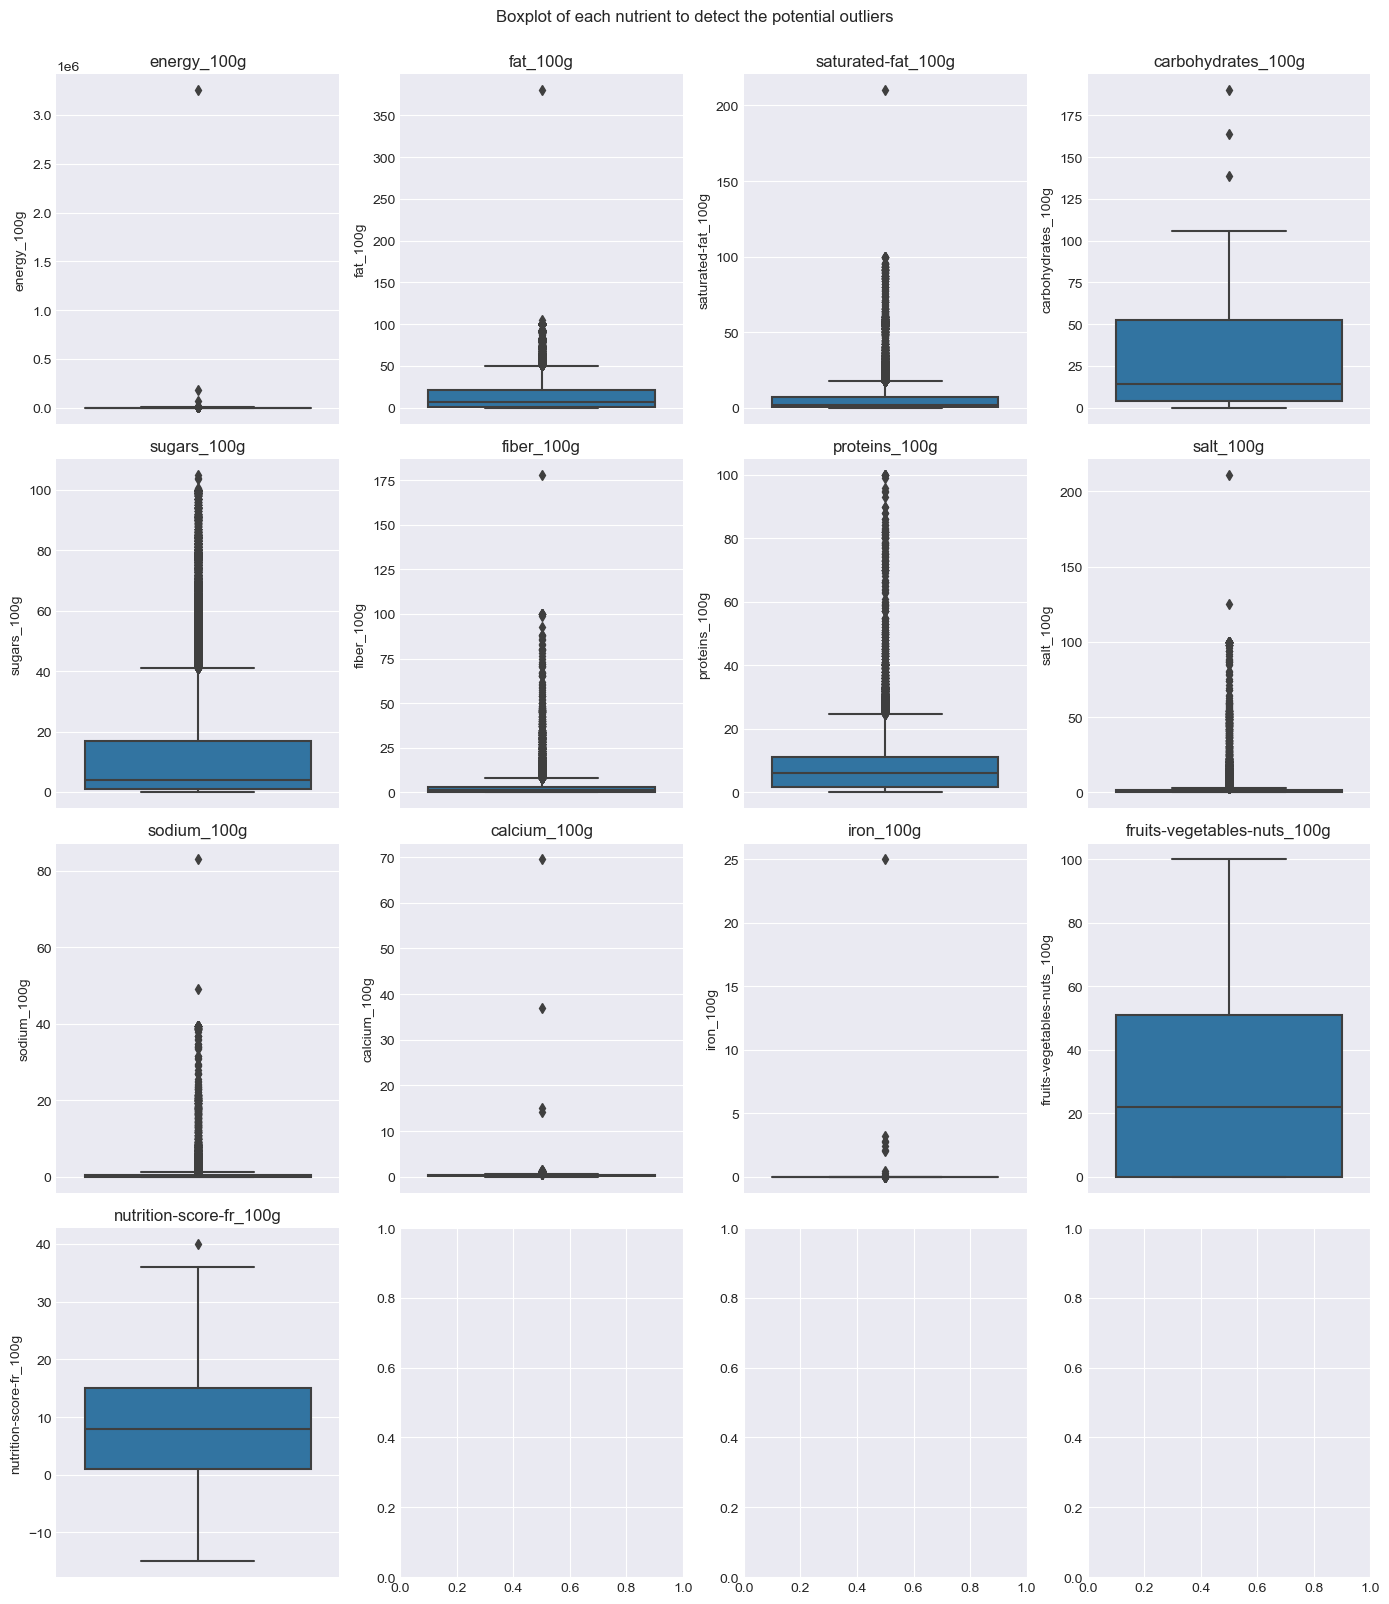

In [16]:
disp_outliers(off_data, plot='boxplot')

Then, we call the function `disp_outliers()` once again to display the distribution to visualize the shape of each numerical feature and to know which method can be used for our case.

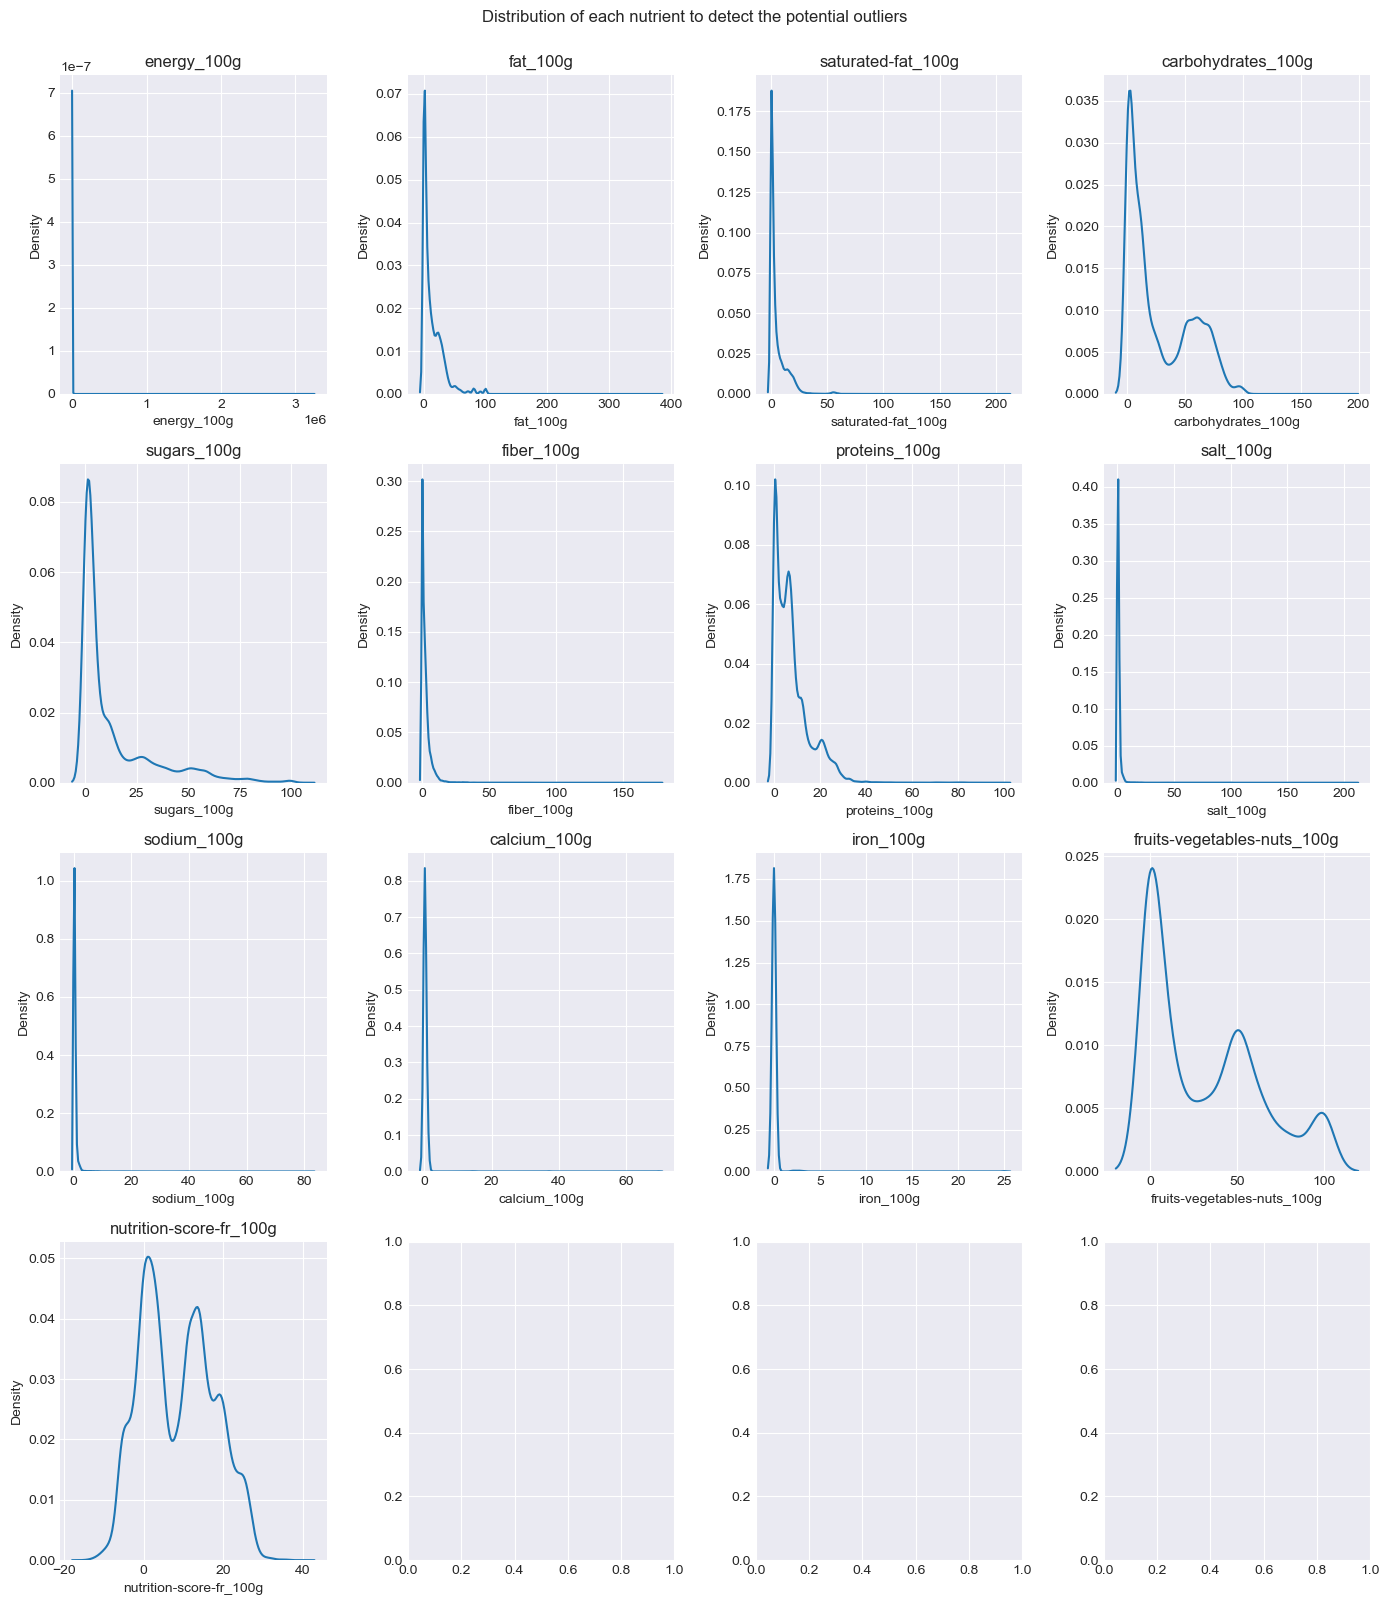

In [17]:
disp_outliers(off_data, plot='kdeplot')

<a id='handle_outliers'></a>
<div style="text-align: justify"> From these distributions, we can notice that they are asymmetric and that we can use the IQR method if we want to get rid of outliers. However, by using the IQR method, we may have to remove the so-called atypical values. To avoid this, we will deal with each column on a case by case basis. </div> <br>

The first case is the columns ending with _100g, we can say that the negative values or higher than 100 are considered as outliers except for the column `energy_100g` which can have a maximum value of 3765.5 kCal as the fat is the most energy dense, at 9 kcal/gram; fat = 9 kcal/g, carbs and protein = 4 kcal/g, alcohol = 7 kcal/g.

A function has been created to handle all these called `handle_outliers()`.

In [18]:
def handle_outliers(df) :
    """handle_outliers returns the input DataFrame df without the outliers.
    
    Parameters:
    df (DataFrame): a DataFrame
    
    Returns:
    DataFrame: Returns the initial DataFrame without the outliers.
    
    """
    for col in df[col_100g]:
        if col == 'energy_100g' :
            # If the energy_100g's value is higher than 3765.5 kCal, we drop the row
            df = df.loc[~(df[col] > 3766), :]
        elif col == 'nutrition-score-fr_100g' :
            # If the nutri-score's value is higher than 40 or lower than -15, we drop the row
            df = df.loc[~((df[col] > 40) & (df[col] < -15)), :]
        else :
            # If the nutriment's value is higher than 100g, we drop the row
            df = df.loc[~(df[col] > 100), :]
            
    df.reset_index(drop=True, inplace=True)

    return df

In [19]:
off_data = handle_outliers(off_data)
display(off_data.head())

,code,product_name,categories_fr,countries_fr,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,calcium_100g,iron_100g,fruits-vegetables-nuts_100g,nutrition-score-fr_100g
0,0000010187319,Mini Confettis,NaN,France,d,NaN,NaN,1753.0,NaN,0.8,NaN,87.7,0.9,0.6,0.0100,0.003937,NaN,NaN,NaN,14.0
1,0000010207260,Praliné Amande Et Noisette,NaN,France,d,NaN,NaN,2406.0,NaN,2.9,NaN,50.3,3.9,9.5,0.0030,0.001181,NaN,NaN,NaN,14.0
2,0000040608754,"Pepsi, Nouveau goût !","Boissons,Boissons gazeuses,Sodas,Sodas au cola...",France,e,Beverages,Sweetened beverages,177.0,0.0,0.0,10.4,10.4,0.0,0.0,0.0254,0.010000,NaN,NaN,NaN,13.0
3,0000069161025,Tarte Poireaux Et Lardons,NaN,France,d,NaN,NaN,1079.0,NaN,11.0,NaN,1.0,1.4,7.5,0.8000,0.314961,NaN,NaN,NaN,15.0
4,0000087177756,7Up,"Aliments et boissons à base de végétaux,Boisso...",France,e,Beverages,Sweetened beverages,177.0,0.0,0.0,10.4,10.4,NaN,0.0,0.1000,0.039370,NaN,NaN,NaN,13.0


### <font color='gray'>Handling and cleaning of the abnormal values</font>

Different conditions are tested to ensure that all undesirable outliers have been modified. The other 'outliers' are not considered as outliers but as atypical.

In [20]:
display(off_data.loc[off_data['saturated-fat_100g'] > off_data.fat_100g])
display(off_data.loc[off_data.sugars_100g > off_data.carbohydrates_100g])
display(off_data.loc[off_data.salt_100g.notna() & off_data.sodium_100g.isna()])
display(off_data.loc[off_data.salt_100g.isna() & off_data.sodium_100g.notna()])

,code,product_name,categories_fr,countries_fr,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,calcium_100g,iron_100g,fruits-vegetables-nuts_100g,nutrition-score-fr_100g
383,0087666052802,Sriracha Stærk Chili Sauce,NaN,France,d,unknown,unknown,510.0,0.00,0.1,28.00,18.00,0.0,1.8,7.31520,2.880000,0.000,0.00000,NaN,14.0
1380,20003432,Amandes en poudre,"Aliments et boissons à base de végétaux,Alimen...",France,d,unknown,unknown,2570.0,54.80,73.8,7.00,5.50,9.4,20.5,0.07000,0.027559,NaN,NaN,NaN,13.0
1542,20031244,Macarons de coco,"Snacks sucrés,Biscuits et gâteaux,Desserts,Gât...",France,e,Sugary snacks,Biscuits and cakes,1990.0,23.00,23.1,60.00,48.00,NaN,4.5,0.20000,0.078740,NaN,NaN,NaN,25.0
1581,20043001,"Favorina, Haselnuss Nougat Eier",NaN,France,e,NaN,NaN,2360.0,9.94,14.5,7.05,48.60,0.0,8.2,0.66040,0.260000,0.048,0.00087,NaN,29.0
3971,26038476,Bonbons Cassis Sans Sucre,"Snacks sucrés,Confiseries,Bonbons",France,b,Sugary snacks,Sweets,1000.0,0.00,0.5,98.00,0.50,0.5,0.0,0.00000,0.000000,NaN,NaN,NaN,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57865,80007760,Ginger San Benedetto,NaN,France,d,NaN,NaN,13.0,0.00,2.5,6.30,1.73,0.0,3.0,6.00000,2.362205,NaN,NaN,NaN,12.0
58363,80050124,Tic Tac - Menthe,"Snacks sucrés,Confiseries,Bonbons",France,d,Sugary snacks,Sweets,1661.0,0.30,0.5,97.50,94.50,0.0,0.1,0.02800,0.011024,NaN,NaN,NaN,14.0
58410,80052043,Tic Tac Menthe,"Snacks sucrés,Confiseries,Bonbons",France,d,Sugary snacks,Sweets,1661.0,0.00,0.5,97.50,94.50,0.0,0.1,0.02800,0.011024,NaN,NaN,NaN,14.0
59172,8076809571487,Buongrano,NaN,France,c,NaN,NaN,1891.0,0.00,1.6,0.00,20.50,8.7,7.7,0.54300,0.213780,NaN,NaN,NaN,7.0


,code,product_name,categories_fr,countries_fr,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,calcium_100g,iron_100g,fruits-vegetables-nuts_100g,nutrition-score-fr_100g
757,0811955011016,Alo exposed,NaN,France,c,NaN,NaN,251.0,0.00,0.0,6.25,15.0,0.0,0.0,0.03048,0.012000,0.017,0.00000,NaN,3.0
1581,20043001,"Favorina, Haselnuss Nougat Eier",NaN,France,e,NaN,NaN,2360.0,9.94,14.5,7.05,48.6,0.0,8.2,0.66040,0.260000,0.048,0.00087,NaN,29.0
1914,20158125,Fromage blanc saveur vanille,"Produits laitiers,Fromages,Fromages blancs",France,b,Milk and dairy products,Cheese,406.0,2.20,1.5,13.00,14.0,0.0,5.4,0.08000,0.031496,NaN,NaN,NaN,2.0
1915,20158132,Fromage blanc 20 % nature,"Produits laitiers,Fromages,Fromages blancs,Pro...",France,a,Milk and dairy products,Cheese,305.0,3.30,2.0,3.50,3.9,0.0,7.3,0.10000,0.039370,NaN,NaN,NaN,-3.0
2036,20197070,Foie gras de canard entier,"Frais,Poissons et viandes et oeufs,Foies gras,...",France,e,unknown,unknown,2276.0,59.90,23.6,1.72,2.2,0.0,7.5,1.27000,0.500000,NaN,NaN,NaN,21.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58045,8001505000856,Mielbio de Châtaignier,"Produits à tartiner,Petit-déjeuners,Produits à...",France,d,Sugary snacks,Sweets,1347.0,0.00,0.0,75.00,80.0,0.0,0.0,0.00000,0.000000,NaN,NaN,NaN,14.0
59172,8076809571487,Buongrano,NaN,France,c,NaN,NaN,1891.0,0.00,1.6,0.00,20.5,8.7,7.7,0.54300,0.213780,NaN,NaN,NaN,7.0
59750,8436045040114,Chiffonade,"Viandes,Charcuteries,Coppa",France,d,Fish Meat Eggs,Processed meat,853.0,8.20,3.1,0.10,0.3,NaN,32.3,4.96000,1.952756,NaN,NaN,NaN,15.0
60202,8480017537188,Filets d'anchois à l'huile d'olive,"Conserves,Produits de la mer,Poissons,Poissons...",France,d,Fish Meat Eggs,Fish and seafood,825.0,11.00,3.2,1.60,2.0,0.0,23.0,15.72000,6.188976,NaN,NaN,NaN,15.0


,code,product_name,categories_fr,countries_fr,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,calcium_100g,iron_100g,fruits-vegetables-nuts_100g,nutrition-score-fr_100g
8278,3083680994613,Jeunes Pousses Batavia-Laitue rouge-Romaine - ...,"Aliments et boissons à base de végétaux,Alimen...",France,NaN,Fruits and vegetables,Vegetables,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.1016,NaN,NaN,NaN,NaN,NaN
49315,3760148290905,Bar sauvage 80 g,"Viandes,Produits à tartiner,Conserves,Charcute...",France,NaN,Fish Meat Eggs,Fish and seafood,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000,NaN,NaN,NaN,NaN,NaN
55519,5906827001303,Kasza Gryczana,NaN,France,NaN,unknown,unknown,1553.0,3.0,0.6,69.0,0.7,6.0,13.0,0.0254,NaN,NaN,NaN,NaN,NaN


,code,product_name,categories_fr,countries_fr,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,calcium_100g,iron_100g,fruits-vegetables-nuts_100g,nutrition-score-fr_100g


<a id='correct_abn_vals'></a>
Another function named `correct_abn_vals()` has been written to get rid of the last abnormal (but not necessarily aberrant) values. As for example if the value of the `sugars_100g` column is higher than the value of the `carbohydrates_100g` column, val(sugars_100g) is abnormal but not outlier. In this case, we adjust the value of the `sugars_100g` column to that of the `carbohydrates_100g` column.

Conditions are applied to the `saturated-fat_100g`, `fat_100g`, `sugars_100g`, `carbohydrates_100g`, `salt_100g`, and `sodium_100g` columns to correct the potential abnormal values.

In [21]:
def correct_abn_vals(df) :
    """correct_abn_vals returns the input DataFrame df without the abnormal values.
    
    Parameters:
    df (DataFrame): a DataFrame
    
    Returns:
    DataFrame: Returns the initial DataFrame without the abnormal values.
    
    """
    # np.where(condition, x if cond true, y if cond false)   
    # If value(saturated-fat_100g) > value(fat_100g), we replace value(saturated-fat_100g) to value(fat_100g)
    df['saturated-fat_100g'] = np.where(df['saturated-fat_100g'] > df.fat_100g, df.fat_100g,
                                            df['saturated-fat_100g'])
 
    # If value(sugars_100g) > value(carbohydrates_100g), we replace value(sugars_100g) to value(carbohydrates_100g)
    df['sugars_100g'] = np.where(df.sugars_100g > df.carbohydrates_100g, df.carbohydrates_100g,
                                            df.sugars_100g)
    
    # If val() is missing but not val() or vice versa, we can complete the missing value by 2.5
    df['sodium_100g'] = np.where((df.salt_100g.notna() & df.sodium_100g.isna()), df.salt_100g/2.5,
                                 df.sodium_100g)
    
    df['salt_100g'] = np.where((df.salt_100g.isna() & df.sodium_100g.notna()), df.sodium_100g*2.5,
                               df.salt_100g)
    
    return df

In [22]:
off_data = correct_abn_vals(off_data)
off_data.head()

,code,product_name,categories_fr,countries_fr,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,calcium_100g,iron_100g,fruits-vegetables-nuts_100g,nutrition-score-fr_100g
0,0000010187319,Mini Confettis,NaN,France,d,NaN,NaN,1753.0,NaN,0.8,NaN,87.7,0.9,0.6,0.0100,0.003937,NaN,NaN,NaN,14.0
1,0000010207260,Praliné Amande Et Noisette,NaN,France,d,NaN,NaN,2406.0,NaN,2.9,NaN,50.3,3.9,9.5,0.0030,0.001181,NaN,NaN,NaN,14.0
2,0000040608754,"Pepsi, Nouveau goût !","Boissons,Boissons gazeuses,Sodas,Sodas au cola...",France,e,Beverages,Sweetened beverages,177.0,0.0,0.0,10.4,10.4,0.0,0.0,0.0254,0.010000,NaN,NaN,NaN,13.0
3,0000069161025,Tarte Poireaux Et Lardons,NaN,France,d,NaN,NaN,1079.0,NaN,11.0,NaN,1.0,1.4,7.5,0.8000,0.314961,NaN,NaN,NaN,15.0
4,0000087177756,7Up,"Aliments et boissons à base de végétaux,Boisso...",France,e,Beverages,Sweetened beverages,177.0,0.0,0.0,10.4,10.4,NaN,0.0,0.1000,0.039370,NaN,NaN,NaN,13.0


In [23]:
display(off_data.loc[off_data['saturated-fat_100g'] > off_data.fat_100g])
display(off_data.loc[off_data.sugars_100g > off_data.carbohydrates_100g])
display(off_data.loc[off_data.salt_100g.notna() & off_data.sodium_100g.isna()])
display(off_data.loc[off_data.salt_100g.isna() & off_data.sodium_100g.notna()])

,code,product_name,categories_fr,countries_fr,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,calcium_100g,iron_100g,fruits-vegetables-nuts_100g,nutrition-score-fr_100g


,code,product_name,categories_fr,countries_fr,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,calcium_100g,iron_100g,fruits-vegetables-nuts_100g,nutrition-score-fr_100g


,code,product_name,categories_fr,countries_fr,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,calcium_100g,iron_100g,fruits-vegetables-nuts_100g,nutrition-score-fr_100g


,code,product_name,categories_fr,countries_fr,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,calcium_100g,iron_100g,fruits-vegetables-nuts_100g,nutrition-score-fr_100g


We can see that the abnormal values have been corrected when we reapply the conditions used previously. We display once again the boxplots and the distributions and we can see a clear improvement on the boxplots plot.

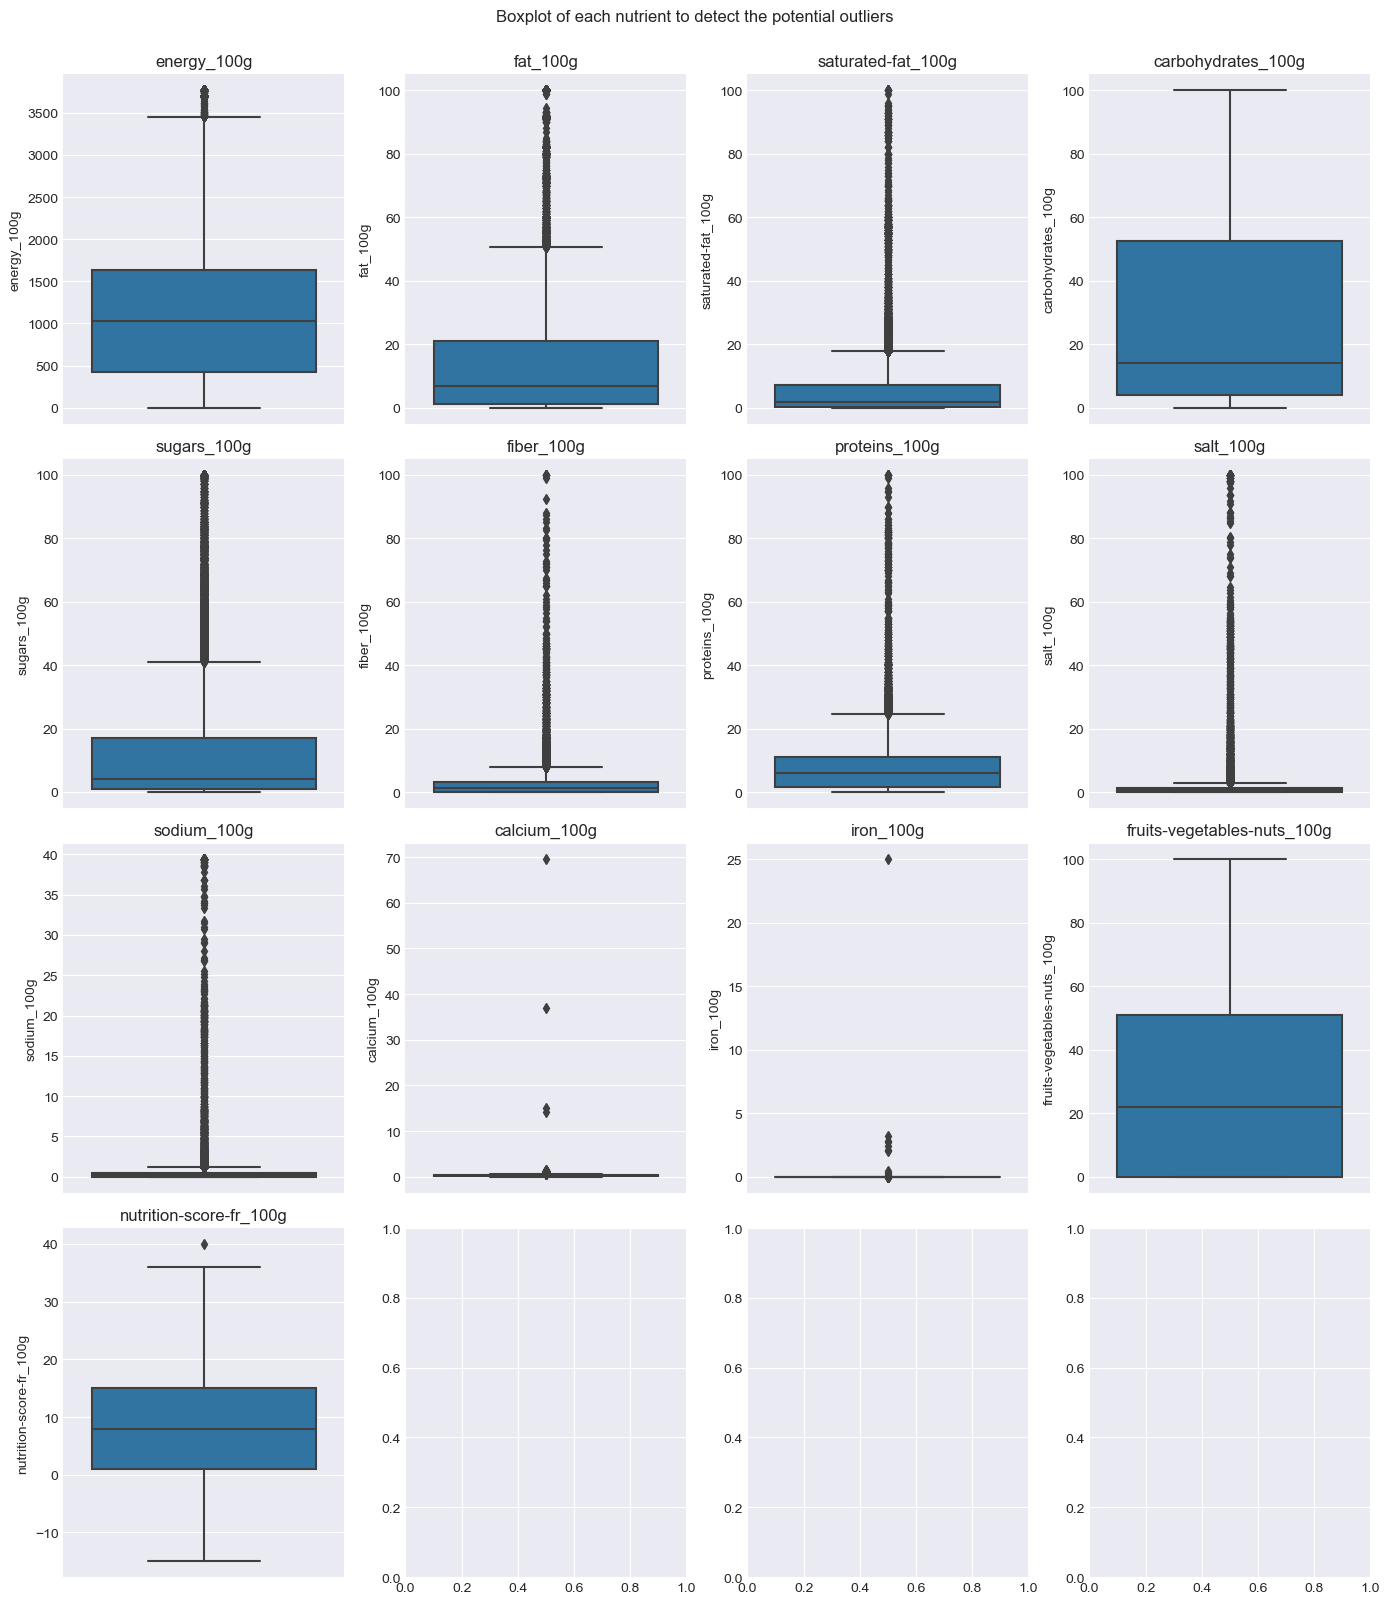

In [24]:
disp_outliers(off_data, plot='boxplot')

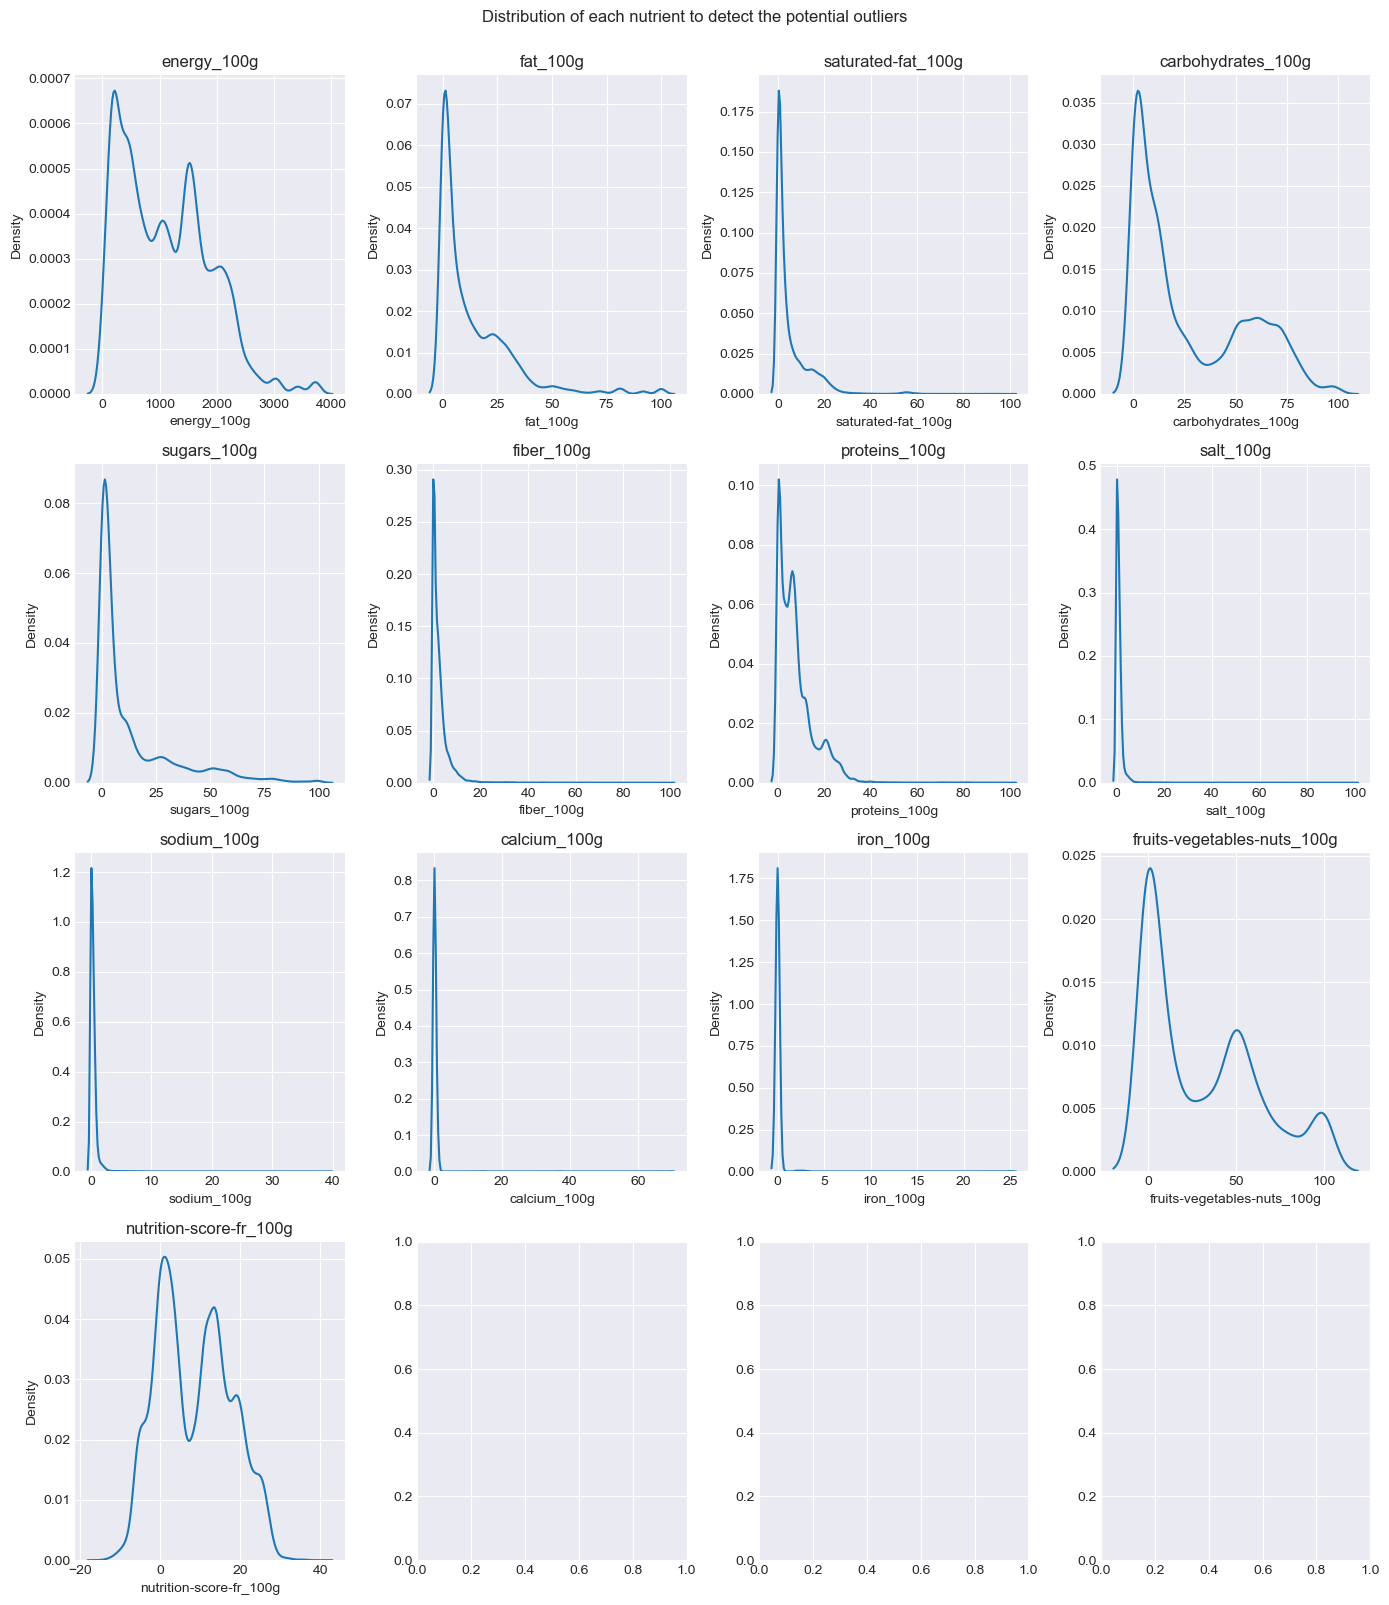

In [25]:
disp_outliers(off_data, plot='kdeplot')

After handling outliers and abnormal values, we see that the distribution of the different features has not been affected by our cleaning. Let's see now if the management of the missing values will affect the modification of the distributions.

### <font color='gray'>Handling and cleaning missing values</font>

After removing the outliers, we can handle the missing values. In that order because if we decide to impute missing values with a KNN or another complex technique but we have kept outliers, the imputation can introduce some biases due to the outliers.

Since the features concerning the different nutrients can be correlated with each other, we will do a more advanced analysis compared to the imputation done for the missing values of the `code` column. By using the `missingno` library, we will be able to :
- get a global view of the whole dataset with the `msno.bar()` function
- then we can focus on the missing values location in the dataset in order to extract patterns on the features if there are any with the function `msno.matrix()` function

In [26]:
off_data.isna().mean()

code                           0.000000
product_name                   0.005138
categories_fr                  0.265881
countries_fr                   0.000000
nutrition_grade_fr             0.059496
pnns_groups_1                  0.222426
pnns_groups_2                  0.220397
energy_100g                    0.012353
fat_100g                       0.282422
saturated-fat_100g             0.045242
carbohydrates_100g             0.289057
sugars_100g                    0.043664
fiber_100g                     0.298608
proteins_100g                  0.016348
salt_100g                      0.042730
sodium_100g                    0.042730
calcium_100g                   0.969286
iron_100g                      0.985295
fruits-vegetables-nuts_100g    0.953501
nutrition-score-fr_100g        0.059496
dtype: float64

In [27]:
off_data.shape

(62088, 20)

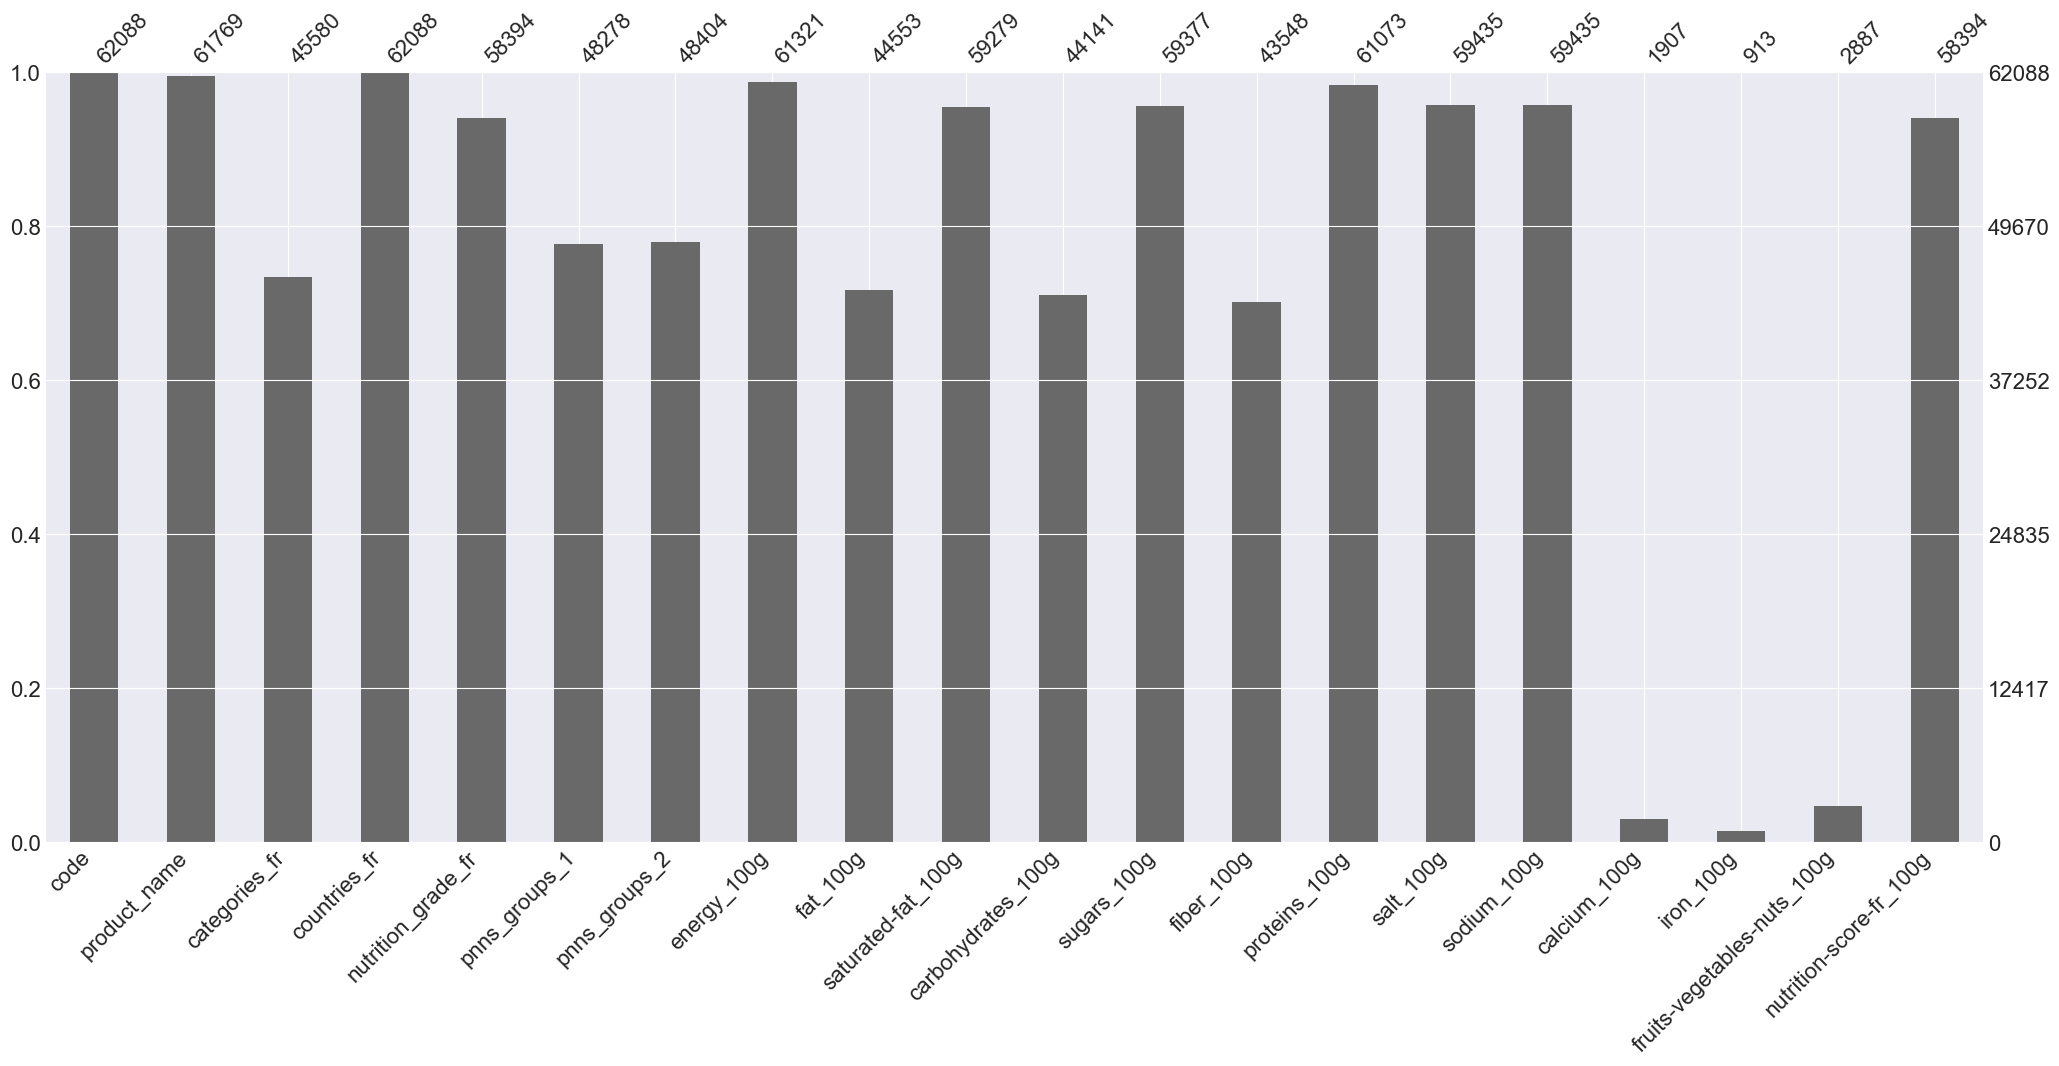

In [28]:
msno.bar(off_data)
plt.show()

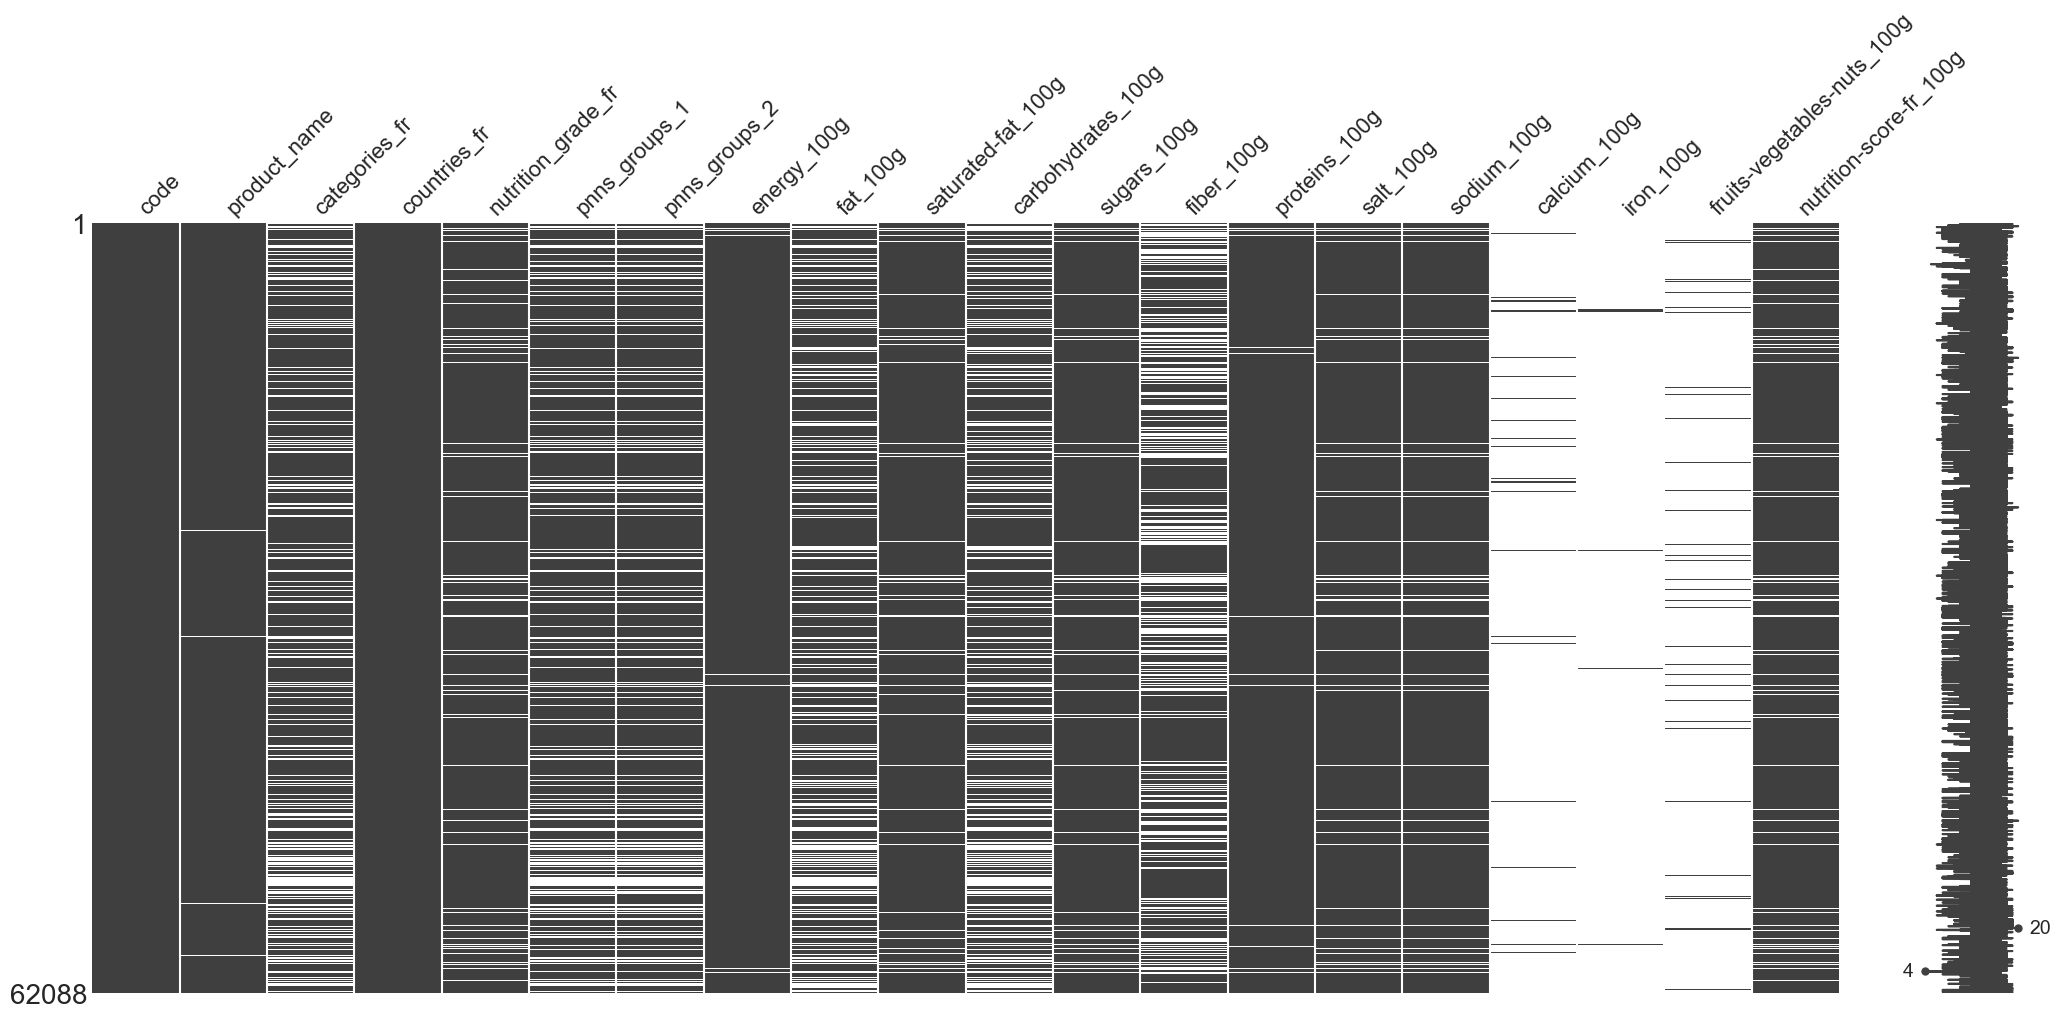

In [29]:
msno.matrix(off_data)
plt.show()

We can see a rather good uniformity of the missingness in the dataset except maybe for the variable `fruit-veg-nuts_100g` where we can spend some time on it in order to analyze it and we can see that some features seem, at a glance, correlated with each other (this is an observation, not a finding) as for `calcium_100g` and `iron_100g` or `nutrition_grade_fr` and `nutrition-score-fr_100g`.

### <font color='gray'>Mecanism of the missing values</font>

There are different types of missing values and having a good understanding of the missingness of the dataset will allow the use of the appropriate imputation technique. There are currently 3 types of missing values :

- The first type of missing values are called __Missing Completely At Random__ (AKA MCAR) : This happens when there is no clear reasoning as to why a certain value in your dataset is missing. MCAR occurs when the missing on the variable is completely unsystematic. When our dataset is missing values completely at random, the probability of missing data is unrelated to any other variable and unrelated to the variable with missing values itself. The missing values of a feature are MCAR if and only if the __probability that the value is missing is independent of the values taken by the other explanatory variables of the observation, whether they are missing or not__. More formally, we write : $\ P(x_{i1\:missing\: \mid \:ij\:observed, \:i1\:missing}) = P(x_{i1\:missing}) $ <br> <br>

- The second type is called __Missing At Random__ (known as MAR) : This is when we can determine some correlation to why the data value may be missing. The missing data of a feature are MAR if and only if the __probability of a missing value is correlated to the existence of features whose values are filled in__. On the other hand, this __probability is not correlated to the absence of feature values__. In other words : $\ P(x_{i1\:missing\: \mid \:ij\:observed,\:i1\:missing}) = P(x_{i1\:missing\: \mid \: ij\:observed}) $ <br> <br>

- The last type of missingness is called __Missing Not At Random__ (also known as MNAR) : This is when we can see a clear pattern to the missing values. The __probability that a feature value is missing or not, depends only on itself and is not correlated with any of the other feature values__. In other words, there is a __pattern that motivates the missingness of a value__ : <br>
$\ P(x_{i1\:missing\: \mid \: ij\:observed,\:i1\:missing}) = P(x_{i1\:missing\: \mid \: ij\:missing}) $ </br>

Unlike the other two types of missing data, MNAR is nonignorable and a complementary analysis has to be done.

To have a better visualization of the missingness, we will use the `msno` library and especially the `heatmap()` function. The missingno correlation heatmap measures nullity correlation: how strongly the presence or absence of one variable affects the presence of another.

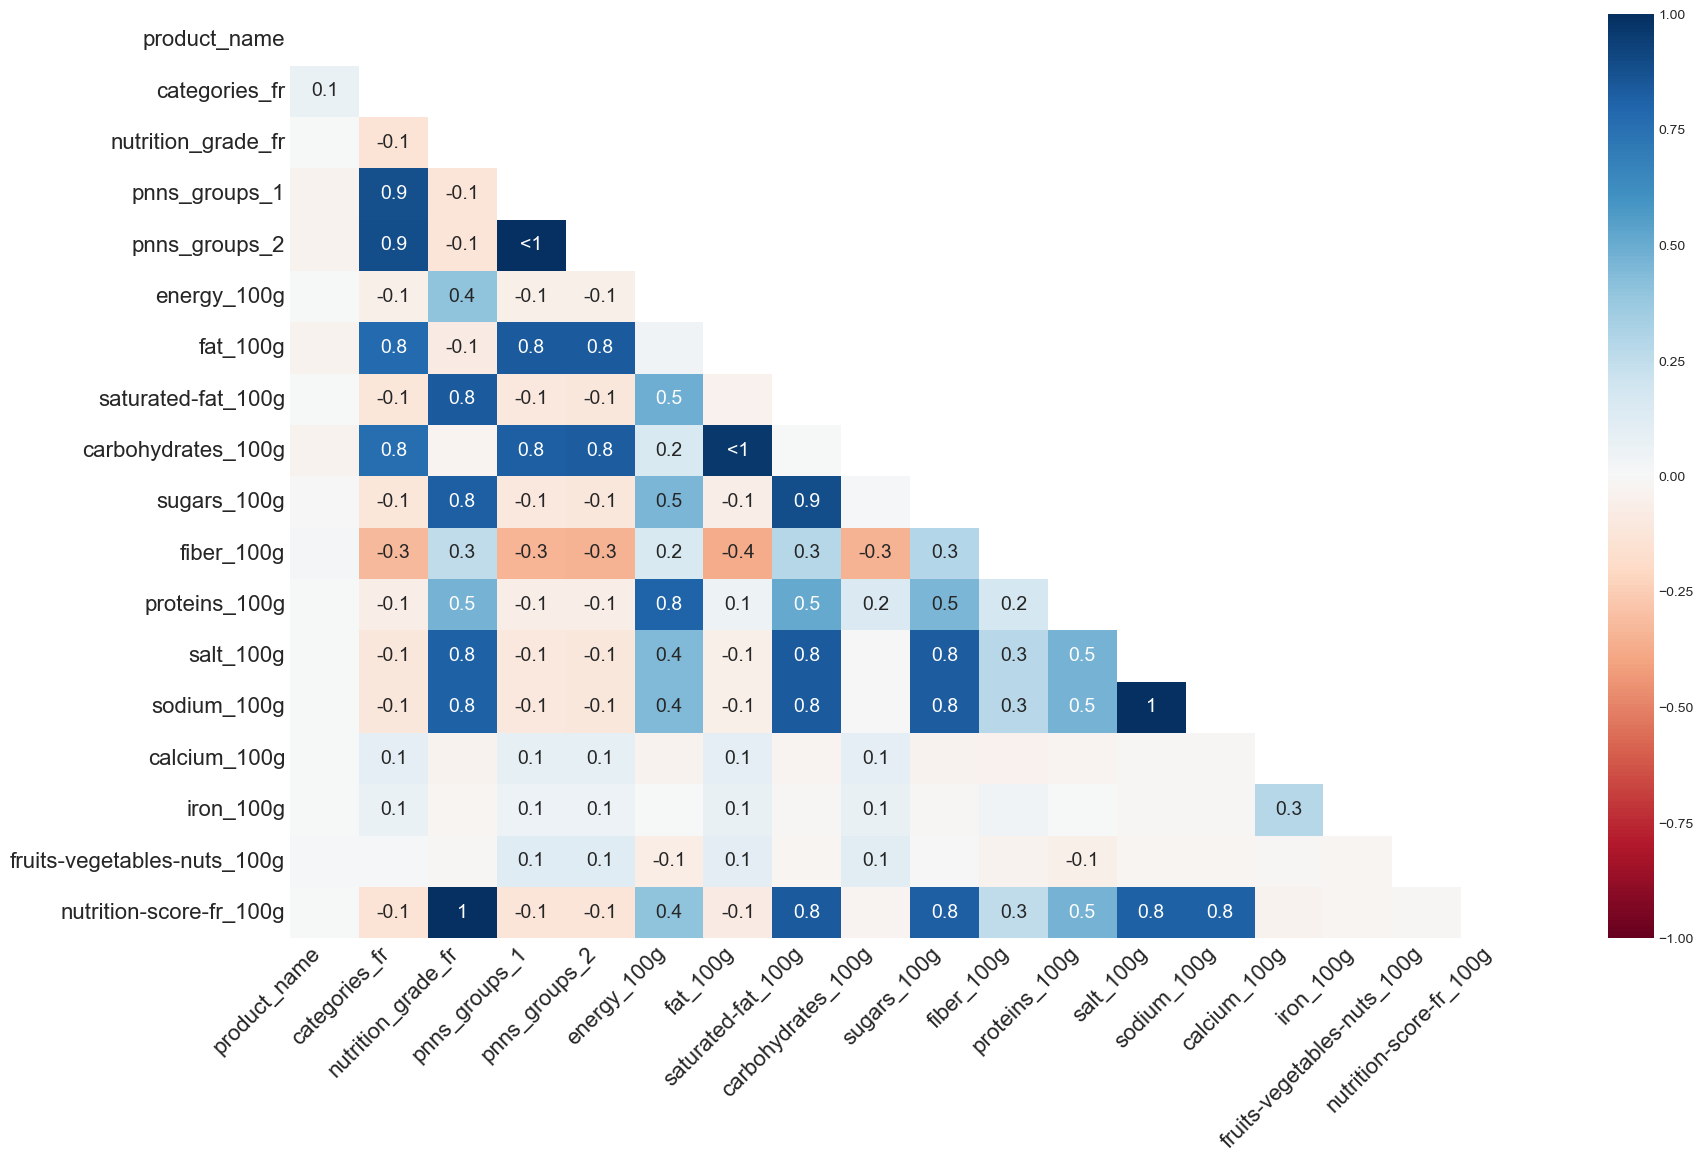

In [30]:
msno.heatmap(off_data)
plt.show()

In [31]:
# We display the correlation matrix between all the numerical variables of the dataset

corr = off_data.corr()

# Fill diagonal and upper half with NaNs
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr[mask] = np.nan
(corr.style.background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
 .highlight_null(null_color='#f1f1f1')  # Color NaNs grey
 .format(precision=2))

,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,calcium_100g,iron_100g,fruits-vegetables-nuts_100g,nutrition-score-fr_100g
energy_100g,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
fat_100g,0.79,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
saturated-fat_100g,0.57,0.74,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
carbohydrates_100g,0.52,-0.08,-0.03,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
sugars_100g,0.32,-0.01,0.07,0.64,nan,nan,nan,nan,nan,nan,nan,nan,nan
fiber_100g,0.20,0.07,0.01,0.25,0.03,nan,nan,nan,nan,nan,nan,nan,nan
proteins_100g,0.20,0.14,0.14,-0.14,-0.25,0.20,nan,nan,nan,nan,nan,nan,nan
salt_100g,-0.02,0.01,0.01,-0.08,-0.09,0.01,0.10,nan,nan,nan,nan,nan,nan
sodium_100g,-0.02,0.01,0.01,-0.08,-0.09,0.01,0.10,1.00,nan,nan,nan,nan,nan
calcium_100g,0.08,0.07,0.07,0.02,-0.00,0.05,0.10,0.01,0.01,nan,nan,nan,nan


In [32]:
off_data.head()

,code,product_name,categories_fr,countries_fr,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,calcium_100g,iron_100g,fruits-vegetables-nuts_100g,nutrition-score-fr_100g
0,0000010187319,Mini Confettis,NaN,France,d,NaN,NaN,1753.0,NaN,0.8,NaN,87.7,0.9,0.6,0.0100,0.003937,NaN,NaN,NaN,14.0
1,0000010207260,Praliné Amande Et Noisette,NaN,France,d,NaN,NaN,2406.0,NaN,2.9,NaN,50.3,3.9,9.5,0.0030,0.001181,NaN,NaN,NaN,14.0
2,0000040608754,"Pepsi, Nouveau goût !","Boissons,Boissons gazeuses,Sodas,Sodas au cola...",France,e,Beverages,Sweetened beverages,177.0,0.0,0.0,10.4,10.4,0.0,0.0,0.0254,0.010000,NaN,NaN,NaN,13.0
3,0000069161025,Tarte Poireaux Et Lardons,NaN,France,d,NaN,NaN,1079.0,NaN,11.0,NaN,1.0,1.4,7.5,0.8000,0.314961,NaN,NaN,NaN,15.0
4,0000087177756,7Up,"Aliments et boissons à base de végétaux,Boisso...",France,e,Beverages,Sweetened beverages,177.0,0.0,0.0,10.4,10.4,NaN,0.0,0.1000,0.039370,NaN,NaN,NaN,13.0


We will dive into handling the missing values. We first are going to compare two imputation methods which are __Multiple Iterative Chained Equation__ (MICE) and __KNNImputer__ method.

### <font color='gray'>Comparison between MICE (Multiple Iterative Chained Equation) and KNNImputer</font>

KNNImputer and IterativeImputer are functions that belong to the scikit-learn module in Python. This module aims to be used for Machine Learning.

- The KNNImputer is used to fill in missing values in a dataset using the k-Nearest Neighbors method. k-Nearest Neighbors algorithm is used for classification and prediction problems. This is a distance-based imputation method and __it requires us to normalize our data__. Otherwise, the different scales of our data will lead the KNN Imputer to generate biased replacements for the missing values. For simplicity, we will use Scikit-Learn’s MinMaxScaler which will scale our variables to have values between 0 and 1. As the value of k is non-parametric, a general rule of thumb in choosing the value of k is __k = sqrt(N)/2__, where N stands for the number of samples. Always try and __keep the value of k odd__, so that there is no tie between choosing a class. The advantages of this method are plenty: it's very easy to implement, used for both classification and regression, the data is not previously assumed, it's very useful in cases of nonlinear data. But it is a bit more expensive as it stores the entire dataset, a high memory storage requirements for this algorithm and highly sensitive to the scale of the data (this is why we have to normalize the data first).

- The MICE ou IterativeImputer function has all of the same benefits as KNN Imputer, producing more accurate estimates of missing values with less manual labor, IterativeImputer uses a different strategy for getting there. Instead, it __regresses a feature with missing values on the dataset’s other features__ and then replaces the missing values with the predicted value from the regression model. Like KNN Imputer, IterativeImputer should replace missing values with the feature mean when there is no relationship between features, as the random regression coefficients offset. Alternatively, when correlations between features do exist, IterativeImputer will base the imputed value on the correlations with all other features. IterativeImputer is __based on the crossed validation method__ : one feature is the target (only the rows that don't have a missing value on that feature is used as a target) and the other features are the training test. Then, a regressor is trained and computed by the training test (the regressor is fitted on). Therefore, the regressor will be allowed to predict missing values on the target. These steps are performed for each feature and then repeated for specified iterations.

To conclude, KNN Imputer and IterativeImputer provide similar benefits and are both superior to traditional methods of imputing missing values.

### <font color='gray'>Imputing missing values with KNNImputer</font>

In [33]:
# Normalizing the DF before using KNNImputer

off_data_col_100g = off_data[col_100g]
scaler = MinMaxScaler()
off_data_kNN = pd.DataFrame(scaler.fit_transform(off_data_col_100g), columns = off_data_col_100g.columns)
off_data_kNN.head()

,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,calcium_100g,iron_100g,fruits-vegetables-nuts_100g,nutrition-score-fr_100g
0,0.465481,NaN,0.008,NaN,0.877123,0.009,0.006,0.000100,0.000100,NaN,NaN,NaN,0.527273
1,0.638874,NaN,0.029,NaN,0.503497,0.039,0.095,0.000030,0.000030,NaN,NaN,NaN,0.527273
2,0.046999,0.0,0.000,0.104,0.104895,0.000,0.000,0.000254,0.000254,NaN,NaN,NaN,0.509091
3,0.286511,NaN,0.110,NaN,0.010989,0.014,0.075,0.008000,0.008000,NaN,NaN,NaN,0.545455
4,0.046999,0.0,0.000,0.104,0.104895,NaN,0.000,0.001000,0.001000,NaN,NaN,NaN,0.509091


In [34]:
# Imputing cols with KNNImputer for cols that are MCAR such as calcium_100g, iron_100g, fruits-vegetables...

impKNN = KNNImputer()
newvalues = impKNN.fit_transform(off_data_kNN)
# Invert MinMaxScaler to get back the initial values
newvalues = scaler.inverse_transform(newvalues)
off_data_kNN = pd.DataFrame(newvalues, columns=col_100g, index=off_data_col_100g.index)
off_data_kNN.head()

,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,calcium_100g,iron_100g,fruits-vegetables-nuts_100g,nutrition-score-fr_100g
0,1753.0,1.00,0.8,23.14,87.7,0.9,0.6,0.0100,0.003937,0.036540,0.017441,14.00,14.0
1,2406.0,29.90,2.9,29.16,50.3,3.9,9.5,0.0030,0.001181,0.018270,0.002841,46.00,14.0
2,177.0,0.00,0.0,10.40,10.4,0.0,0.0,0.0254,0.010000,0.167380,0.000030,22.38,13.0
3,1079.0,11.52,11.0,34.42,1.0,1.4,7.5,0.8000,0.314961,0.021080,0.013031,11.76,15.0
4,177.0,0.00,0.0,10.40,10.4,0.0,0.0,0.1000,0.039370,0.038784,0.000030,22.38,13.0


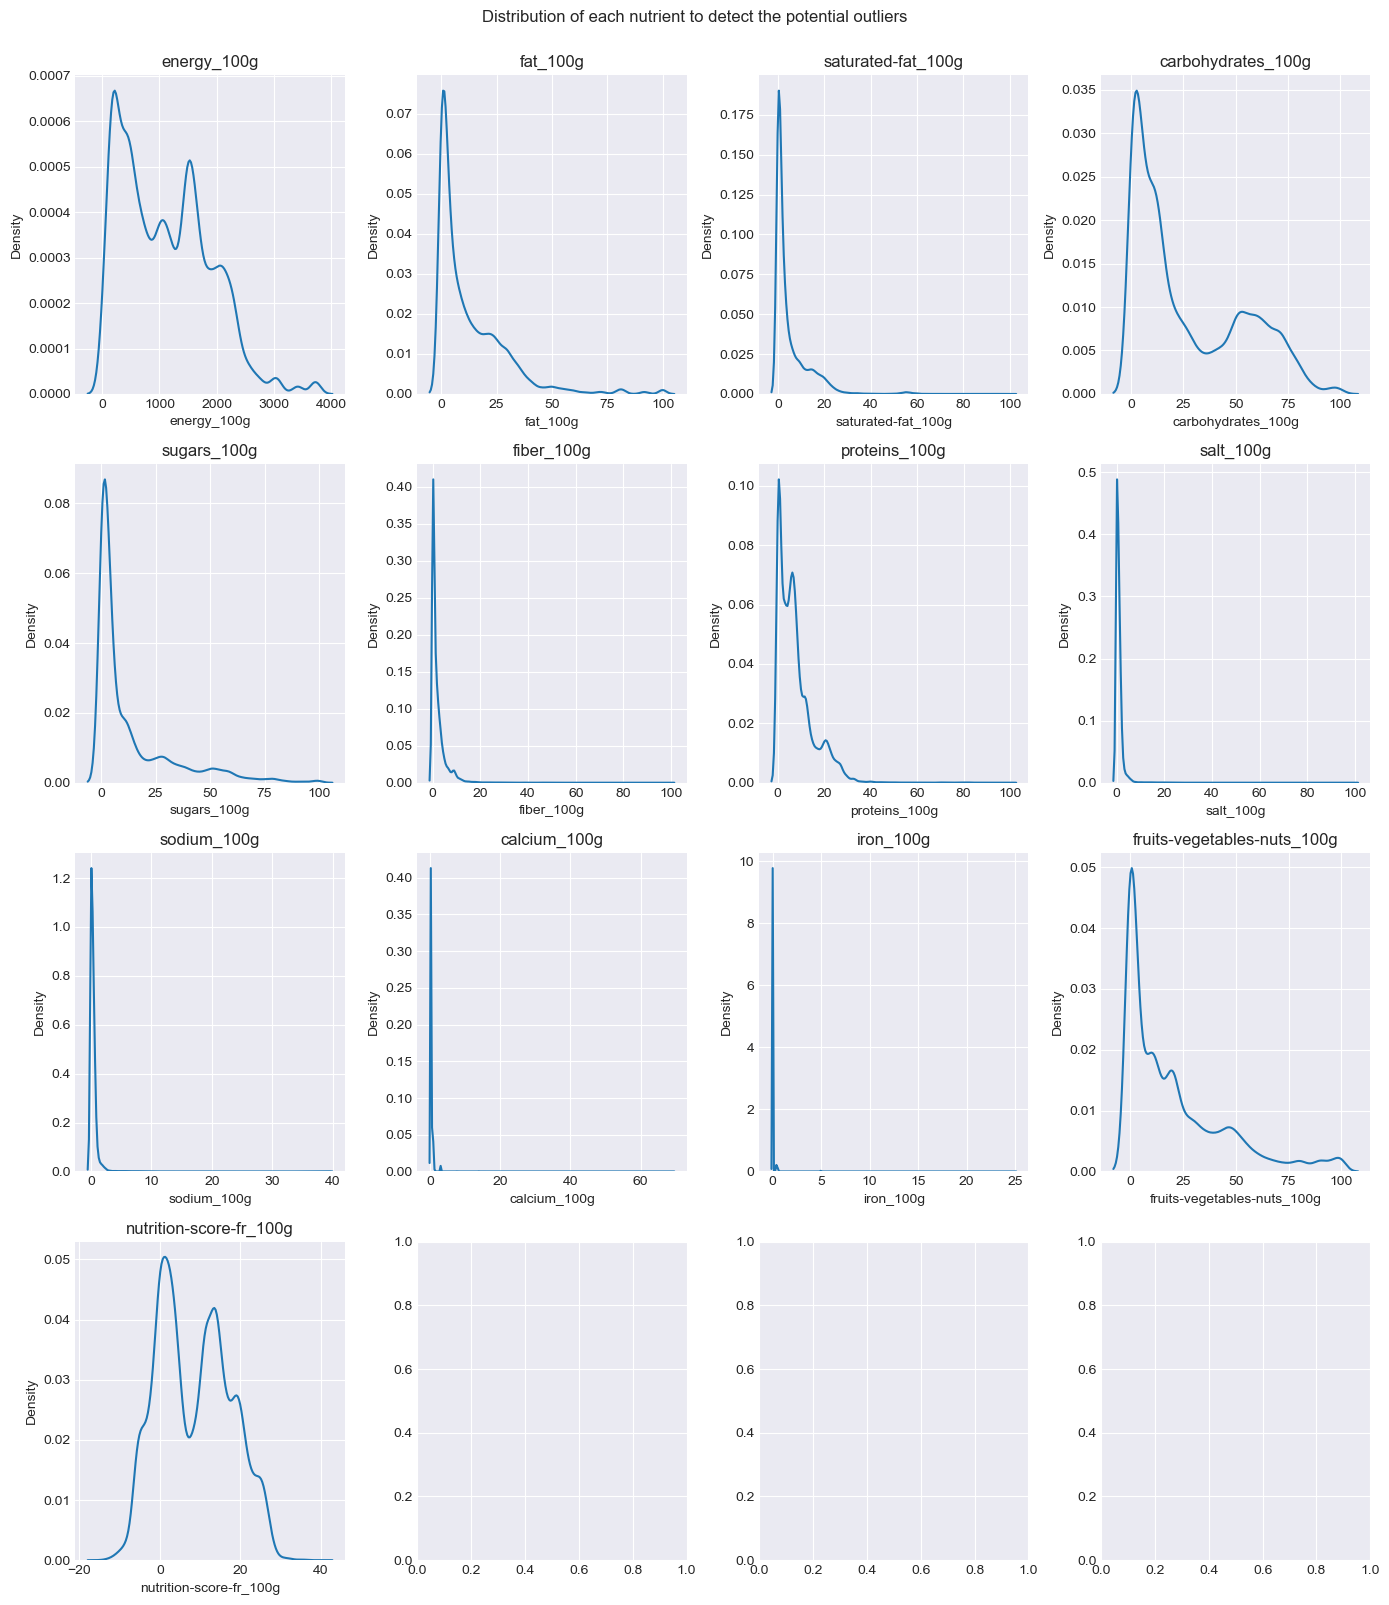

In [35]:
disp_outliers(off_data_kNN, plot='kdeplot')

In [36]:
off_data_kNN.loc[off_data_kNN['sugars_100g'] < 0]

,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,calcium_100g,iron_100g,fruits-vegetables-nuts_100g,nutrition-score-fr_100g
10071,1379.0,30.0,21.0,0.8,-0.1,0.12,15.3,1.4,0.551181,0.35,0.013631,0.0,15.0


In [37]:
off_data_kNN.isna().sum()

energy_100g                    0
fat_100g                       0
saturated-fat_100g             0
carbohydrates_100g             0
sugars_100g                    0
fiber_100g                     0
proteins_100g                  0
salt_100g                      0
sodium_100g                    0
calcium_100g                   0
iron_100g                      0
fruits-vegetables-nuts_100g    0
nutrition-score-fr_100g        0
dtype: int64

In [38]:
# Displaying the correlation matrix between all the numerical variables of the dataset

corr_kNN = off_data_kNN.corr()

# Fill diagonal and upper half with NaNs
mask = np.zeros_like(corr_kNN, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr_kNN[mask] = np.nan
(corr_kNN.style.background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
 .highlight_null(null_color='#f1f1f1')  # Color NaNs grey
 .format(precision=2))

,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,calcium_100g,iron_100g,fruits-vegetables-nuts_100g,nutrition-score-fr_100g
energy_100g,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
fat_100g,0.77,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
saturated-fat_100g,0.58,0.68,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
carbohydrates_100g,0.50,-0.06,-0.02,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
sugars_100g,0.32,-0.02,0.07,0.60,nan,nan,nan,nan,nan,nan,nan,nan,nan
fiber_100g,0.16,0.03,-0.02,0.19,0.02,nan,nan,nan,nan,nan,nan,nan,nan
proteins_100g,0.20,0.20,0.15,-0.12,-0.25,0.15,nan,nan,nan,nan,nan,nan,nan
salt_100g,-0.02,0.01,0.01,-0.07,-0.09,0.00,0.10,nan,nan,nan,nan,nan,nan
sodium_100g,-0.02,0.01,0.01,-0.07,-0.09,0.00,0.10,1.00,nan,nan,nan,nan,nan
calcium_100g,0.02,0.03,0.05,-0.04,-0.03,-0.01,0.14,0.05,0.05,nan,nan,nan,nan


### <font color='gray'>Imputing missing values with IterativeImputer</font>

In [39]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

In [40]:
# Testing IterativeImputer function on the whole dataset

IteratImp = IterativeImputer(max_iter=30, tol=0.003)
newvalues = IteratImp.fit_transform(off_data_col_100g)
off_data_IterImp = pd.DataFrame(newvalues, columns=col_100g, index=off_data_col_100g.index)

In [41]:
off_data_IterImp.isna().sum()

energy_100g                    0
fat_100g                       0
saturated-fat_100g             0
carbohydrates_100g             0
sugars_100g                    0
fiber_100g                     0
proteins_100g                  0
salt_100g                      0
sodium_100g                    0
calcium_100g                   0
iron_100g                      0
fruits-vegetables-nuts_100g    0
nutrition-score-fr_100g        0
dtype: int64

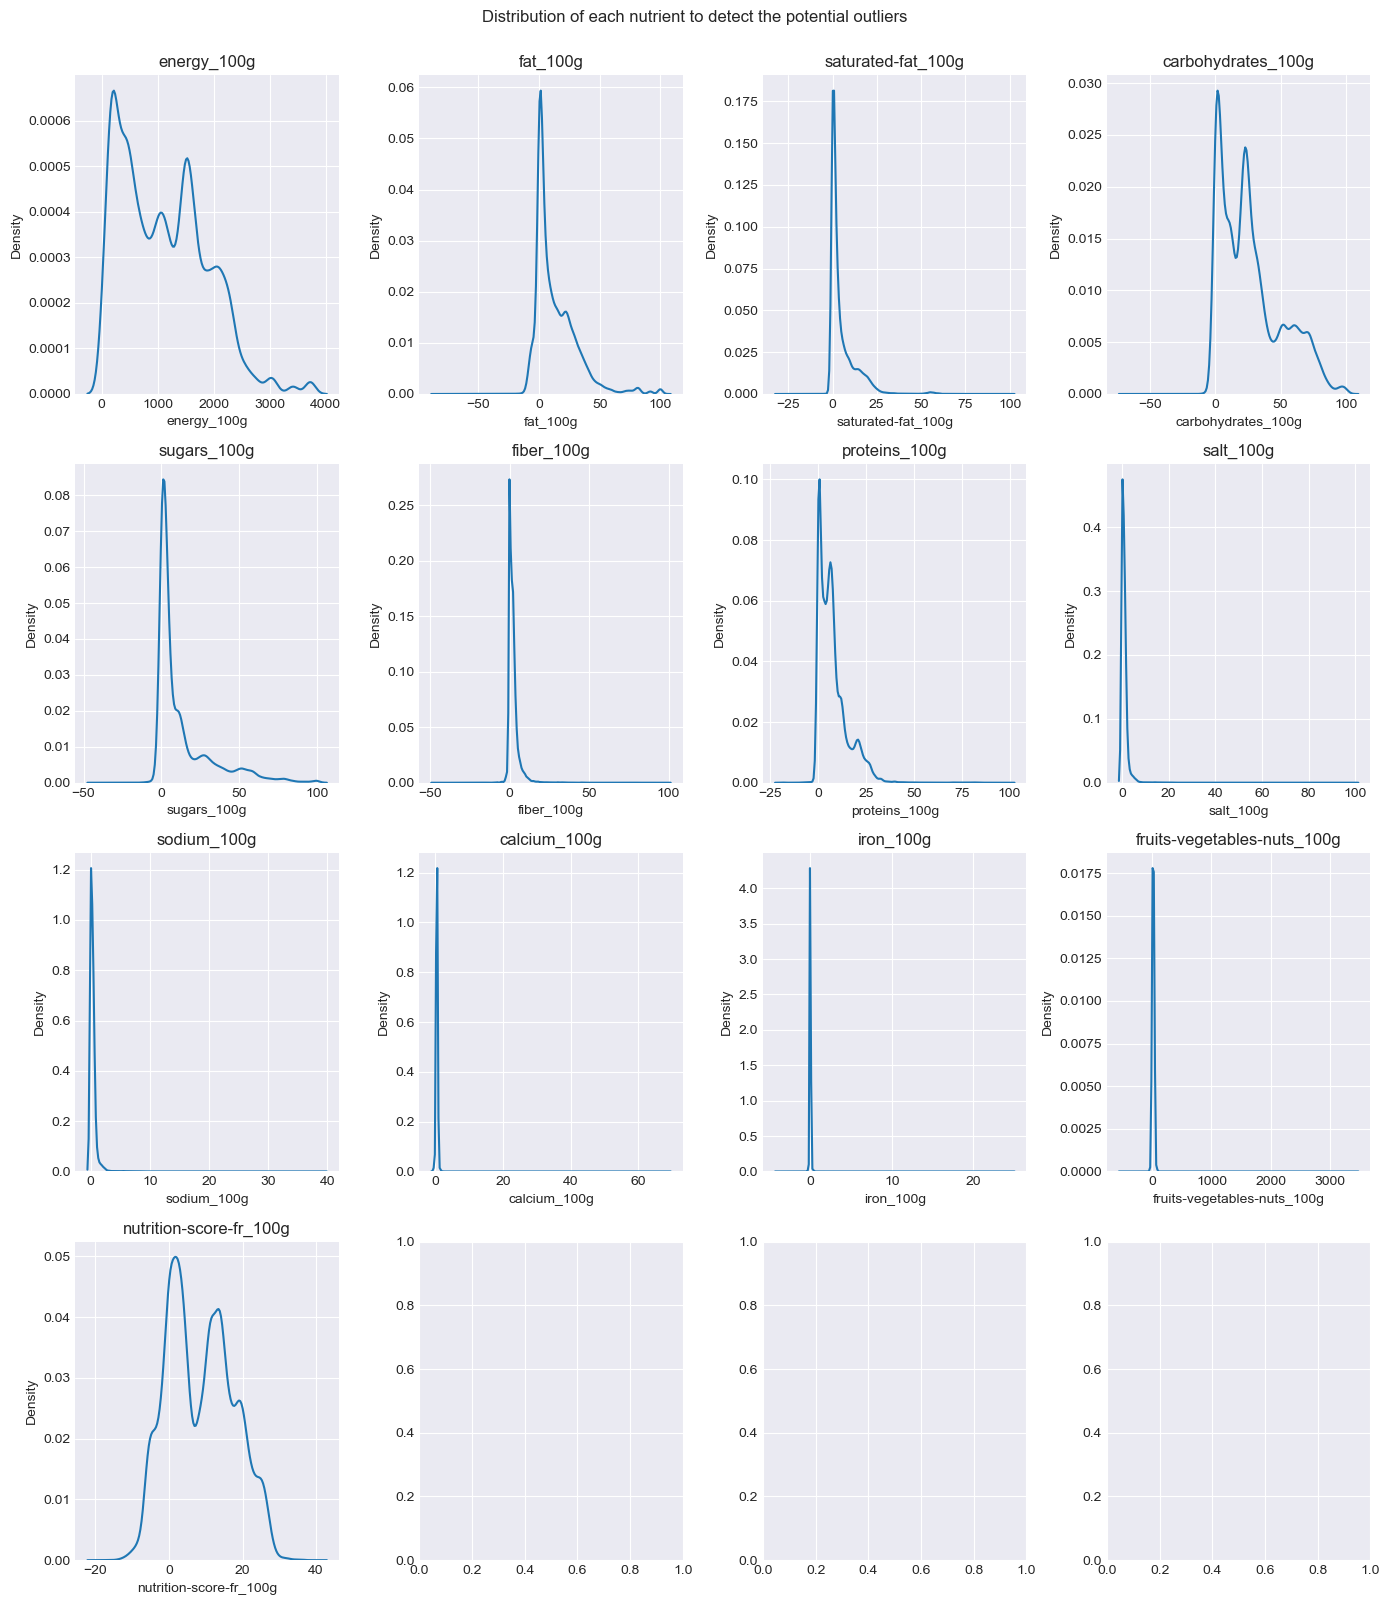

In [42]:
disp_outliers(off_data_IterImp, plot='kdeplot')

In [43]:
off_data_IterImp.loc[off_data_IterImp['sugars_100g'] < 0]

,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,calcium_100g,iron_100g,fruits-vegetables-nuts_100g,nutrition-score-fr_100g
57,2536.0,55.400000,5.000000,4.600000,-4.110277,2.611763,22.20,0.036830,0.014500,0.242000,-0.128764,-25.101350,13.127893
447,1238.0,25.000000,20.000000,0.655667,-0.943634,2.223114,18.00,1.400000,0.551181,0.530141,0.133028,4.848171,13.359267
452,377.0,1.480498,3.205651,1.180000,-1.937718,1.731795,18.50,1.154947,0.454702,0.584976,0.089673,17.101480,4.730941
455,448.0,2.000000,3.218802,0.000000,-1.809458,2.431589,22.00,1.154947,0.454702,0.627910,0.101951,15.843440,4.540995
559,882.0,15.000000,6.907695,0.000000,-1.819537,2.231899,19.00,1.154944,0.454702,0.574879,0.072088,12.368840,7.515187
...,...,...,...,...,...,...,...,...,...,...,...,...,...
60204,1003.0,19.000000,7.934448,0.500000,-1.089149,2.033563,17.00,1.154944,0.454701,0.539097,0.057944,12.499637,8.377218
60205,1042.0,18.800000,8.163312,0.000000,-2.830100,2.385688,20.00,1.154944,0.454702,0.593808,0.073094,9.065159,8.533800
60946,1590.0,5.730000,2.470000,0.100000,-24.284963,6.470000,66.33,1.154943,0.454702,1.413407,0.241391,-39.095421,6.874379
61284,3700.0,100.000000,11.000000,0.000000,-4.233349,-0.153470,0.00,1.154935,0.454701,0.241149,-0.261908,-8.705056,21.063836


In [44]:
# Displaying the correlation matrix between all the numerical variables of the dataset

corr_IterImp = off_data_IterImp.corr()

# Fill diagonal and upper half with NaNs
mask = np.zeros_like(corr_IterImp, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr_IterImp[mask] = np.nan
(corr_IterImp.style.background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
 .highlight_null(null_color='#f1f1f1')  # Color NaNs grey
 .format(precision=2))

,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,calcium_100g,iron_100g,fruits-vegetables-nuts_100g,nutrition-score-fr_100g
energy_100g,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
fat_100g,0.84,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
saturated-fat_100g,0.58,0.69,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
carbohydrates_100g,0.47,-0.03,-0.05,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
sugars_100g,0.31,0.06,0.06,0.59,nan,nan,nan,nan,nan,nan,nan,nan,nan
fiber_100g,0.21,0.01,0.02,0.20,0.06,nan,nan,nan,nan,nan,nan,nan,nan
proteins_100g,0.20,0.10,0.15,-0.12,-0.26,0.19,nan,nan,nan,nan,nan,nan,nan
salt_100g,-0.02,-0.01,0.01,-0.07,-0.09,-0.00,0.10,nan,nan,nan,nan,nan,nan
sodium_100g,-0.02,-0.01,0.01,-0.07,-0.09,-0.00,0.10,1.00,nan,nan,nan,nan,nan
calcium_100g,0.06,-0.00,0.02,-0.01,-0.11,0.05,0.33,0.07,0.07,nan,nan,nan,nan


In summary, the results observed seem to tell us that we would consider an imputation with the KNNImputer algorithm rather than the MICE method.

## Join imputed numerical features and categorical features

After imputing all the missing values for the numerical features, we start to join them with the categorical ones.

In [45]:
off_data_cat = off_data.select_dtypes(exclude=['int64','float64'])
off_data_cat.head()

,code,product_name,categories_fr,countries_fr,nutrition_grade_fr,pnns_groups_1,pnns_groups_2
0,0000010187319,Mini Confettis,NaN,France,d,NaN,NaN
1,0000010207260,Praliné Amande Et Noisette,NaN,France,d,NaN,NaN
2,0000040608754,"Pepsi, Nouveau goût !","Boissons,Boissons gazeuses,Sodas,Sodas au cola...",France,e,Beverages,Sweetened beverages
3,0000069161025,Tarte Poireaux Et Lardons,NaN,France,d,NaN,NaN
4,0000087177756,7Up,"Aliments et boissons à base de végétaux,Boisso...",France,e,Beverages,Sweetened beverages


In [46]:
off_data = pd.concat([off_data_cat, off_data_kNN], axis=1)
off_data.head()

,code,product_name,categories_fr,countries_fr,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,calcium_100g,iron_100g,fruits-vegetables-nuts_100g,nutrition-score-fr_100g
0,0000010187319,Mini Confettis,NaN,France,d,NaN,NaN,1753.0,1.00,0.8,23.14,87.7,0.9,0.6,0.0100,0.003937,0.036540,0.017441,14.00,14.0
1,0000010207260,Praliné Amande Et Noisette,NaN,France,d,NaN,NaN,2406.0,29.90,2.9,29.16,50.3,3.9,9.5,0.0030,0.001181,0.018270,0.002841,46.00,14.0
2,0000040608754,"Pepsi, Nouveau goût !","Boissons,Boissons gazeuses,Sodas,Sodas au cola...",France,e,Beverages,Sweetened beverages,177.0,0.00,0.0,10.40,10.4,0.0,0.0,0.0254,0.010000,0.167380,0.000030,22.38,13.0
3,0000069161025,Tarte Poireaux Et Lardons,NaN,France,d,NaN,NaN,1079.0,11.52,11.0,34.42,1.0,1.4,7.5,0.8000,0.314961,0.021080,0.013031,11.76,15.0
4,0000087177756,7Up,"Aliments et boissons à base de végétaux,Boisso...",France,e,Beverages,Sweetened beverages,177.0,0.00,0.0,10.40,10.4,0.0,0.0,0.1000,0.039370,0.038784,0.000030,22.38,13.0


In [47]:
off_data.isna().sum()

code                               0
product_name                     319
categories_fr                  16508
countries_fr                       0
nutrition_grade_fr              3694
pnns_groups_1                  13810
pnns_groups_2                  13684
energy_100g                        0
fat_100g                           0
saturated-fat_100g                 0
carbohydrates_100g                 0
sugars_100g                        0
fiber_100g                         0
proteins_100g                      0
salt_100g                          0
sodium_100g                        0
calcium_100g                       0
iron_100g                          0
fruits-vegetables-nuts_100g        0
nutrition-score-fr_100g            0
dtype: int64

<a id='correct_abn_vals_aft_imp'></a>
After imputing and merging the dataset, we want to make sure that there are no outliers or abnormal values left. To do this, we write a function `correct_abn_vals_aft_imp()`, which checks and corrects if there are any left.

In [48]:
def correct_abn_vals_aft_imp(df) :
    """correct_abn_vals_aft_imp returns the input DataFrame df with correction performed after imputations.
    
    Parameters:
    df (DataFrame): a DataFrame
    
    Returns:
    DataFrame: Returns the initial DataFrame with corrections if needed.
    
    """
    df = correct_abn_vals(df)
    
    for i in col_100g :
        # Check if the energy's range is between 0 to 3766 kJ, if not we set the min to 0 and max to 3766
        if i == 'energy_100g' :
            df.loc[df[i] < 0, :] = 0
            df.loc[df[i] > 3766, :] = 0
        # Check if any nutrient is negative, if so we set the value to 0
        elif not i == 'nutrition-score-fr_100g' :
            df.loc[df[i] < 0, :] = 0
        else :
            df.loc[df[i] < -15, :] = -15
            df.loc[df[i] > 40, :] = 40
    
    return df

In [49]:
off_data_f = correct_abn_vals_aft_imp(off_data)

We want to make sure that there is no abnormal values left.

In [50]:
off_data_f.loc[off_data_f.sugars_100g < 0]

,code,product_name,categories_fr,countries_fr,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,calcium_100g,iron_100g,fruits-vegetables-nuts_100g,nutrition-score-fr_100g


We call the function `disp_outliers()` to have a better visualization of the numerical features.

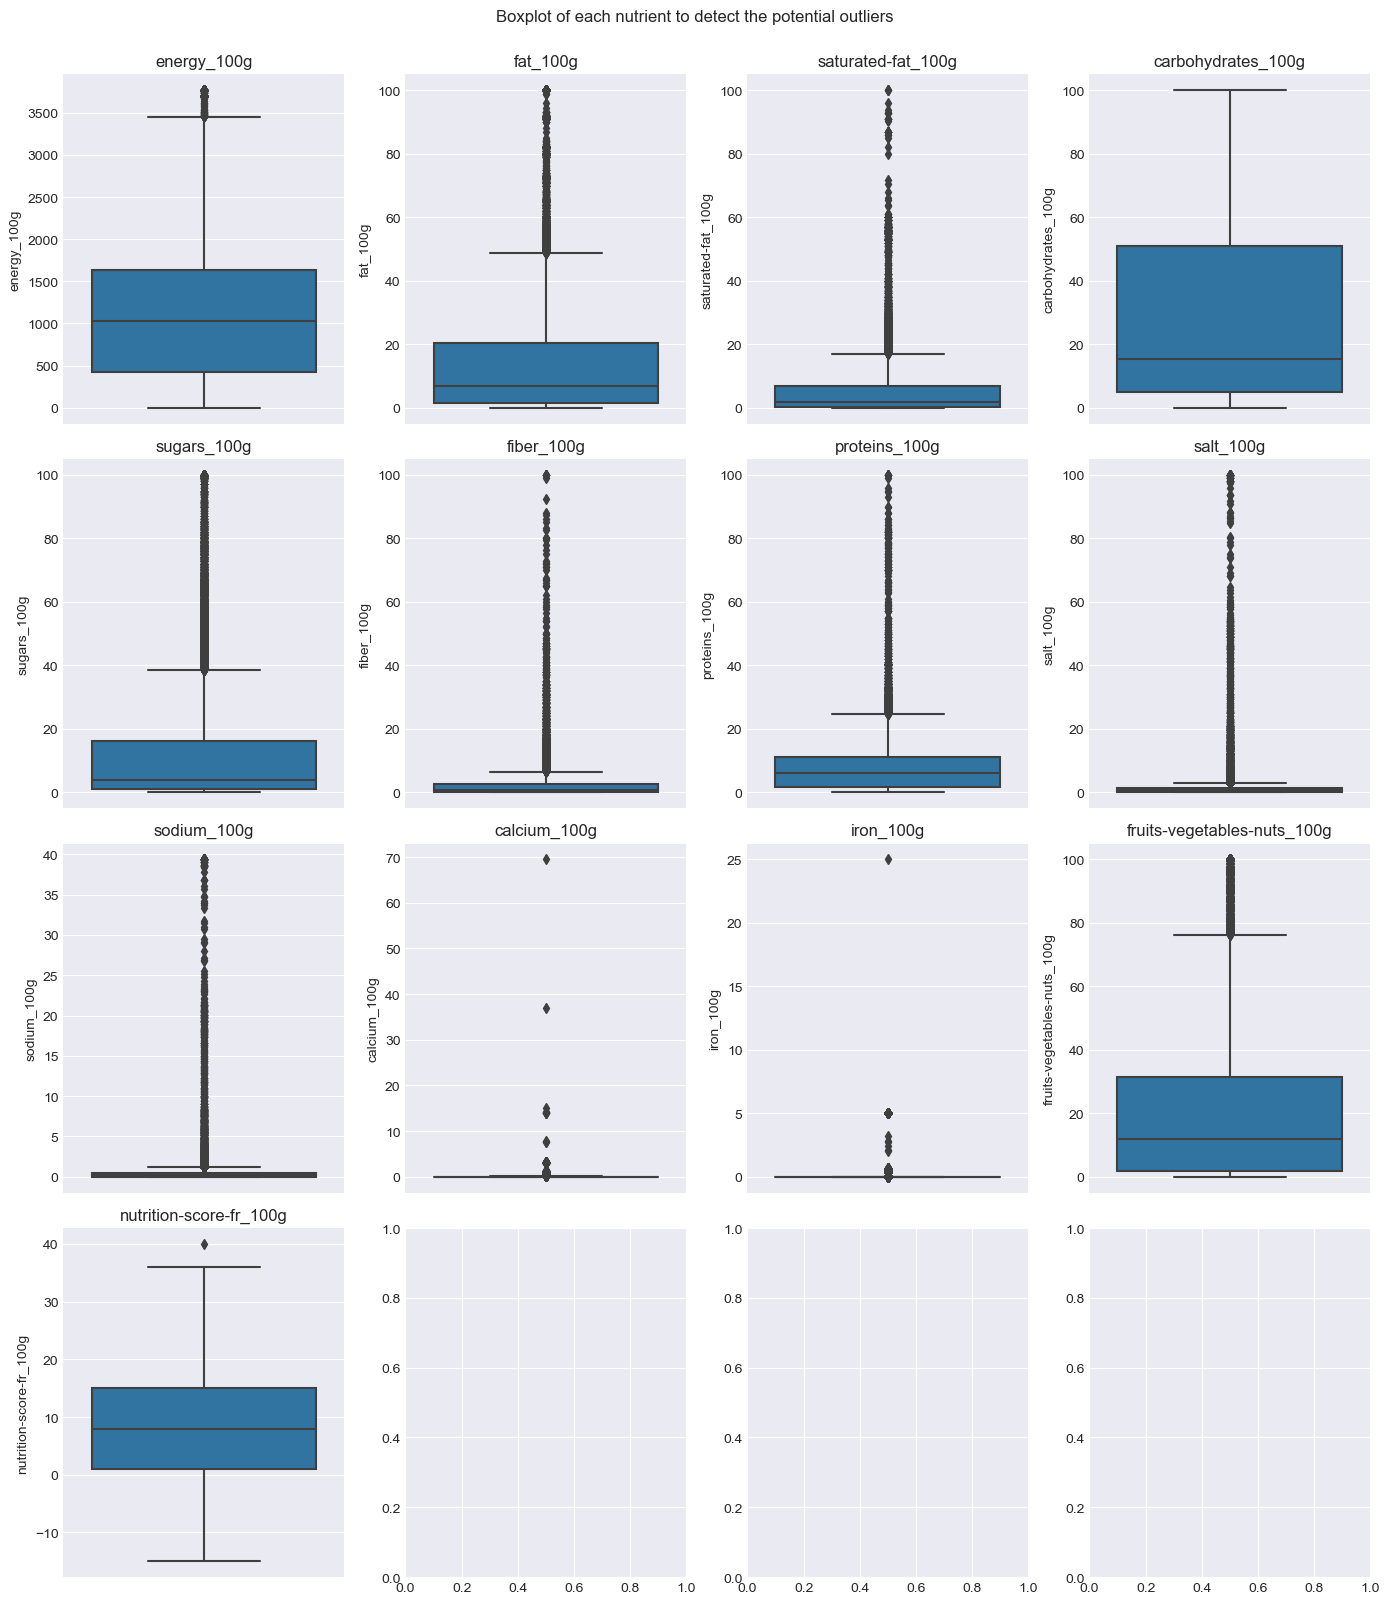

In [51]:
disp_outliers(off_data_f, plot='boxplot')

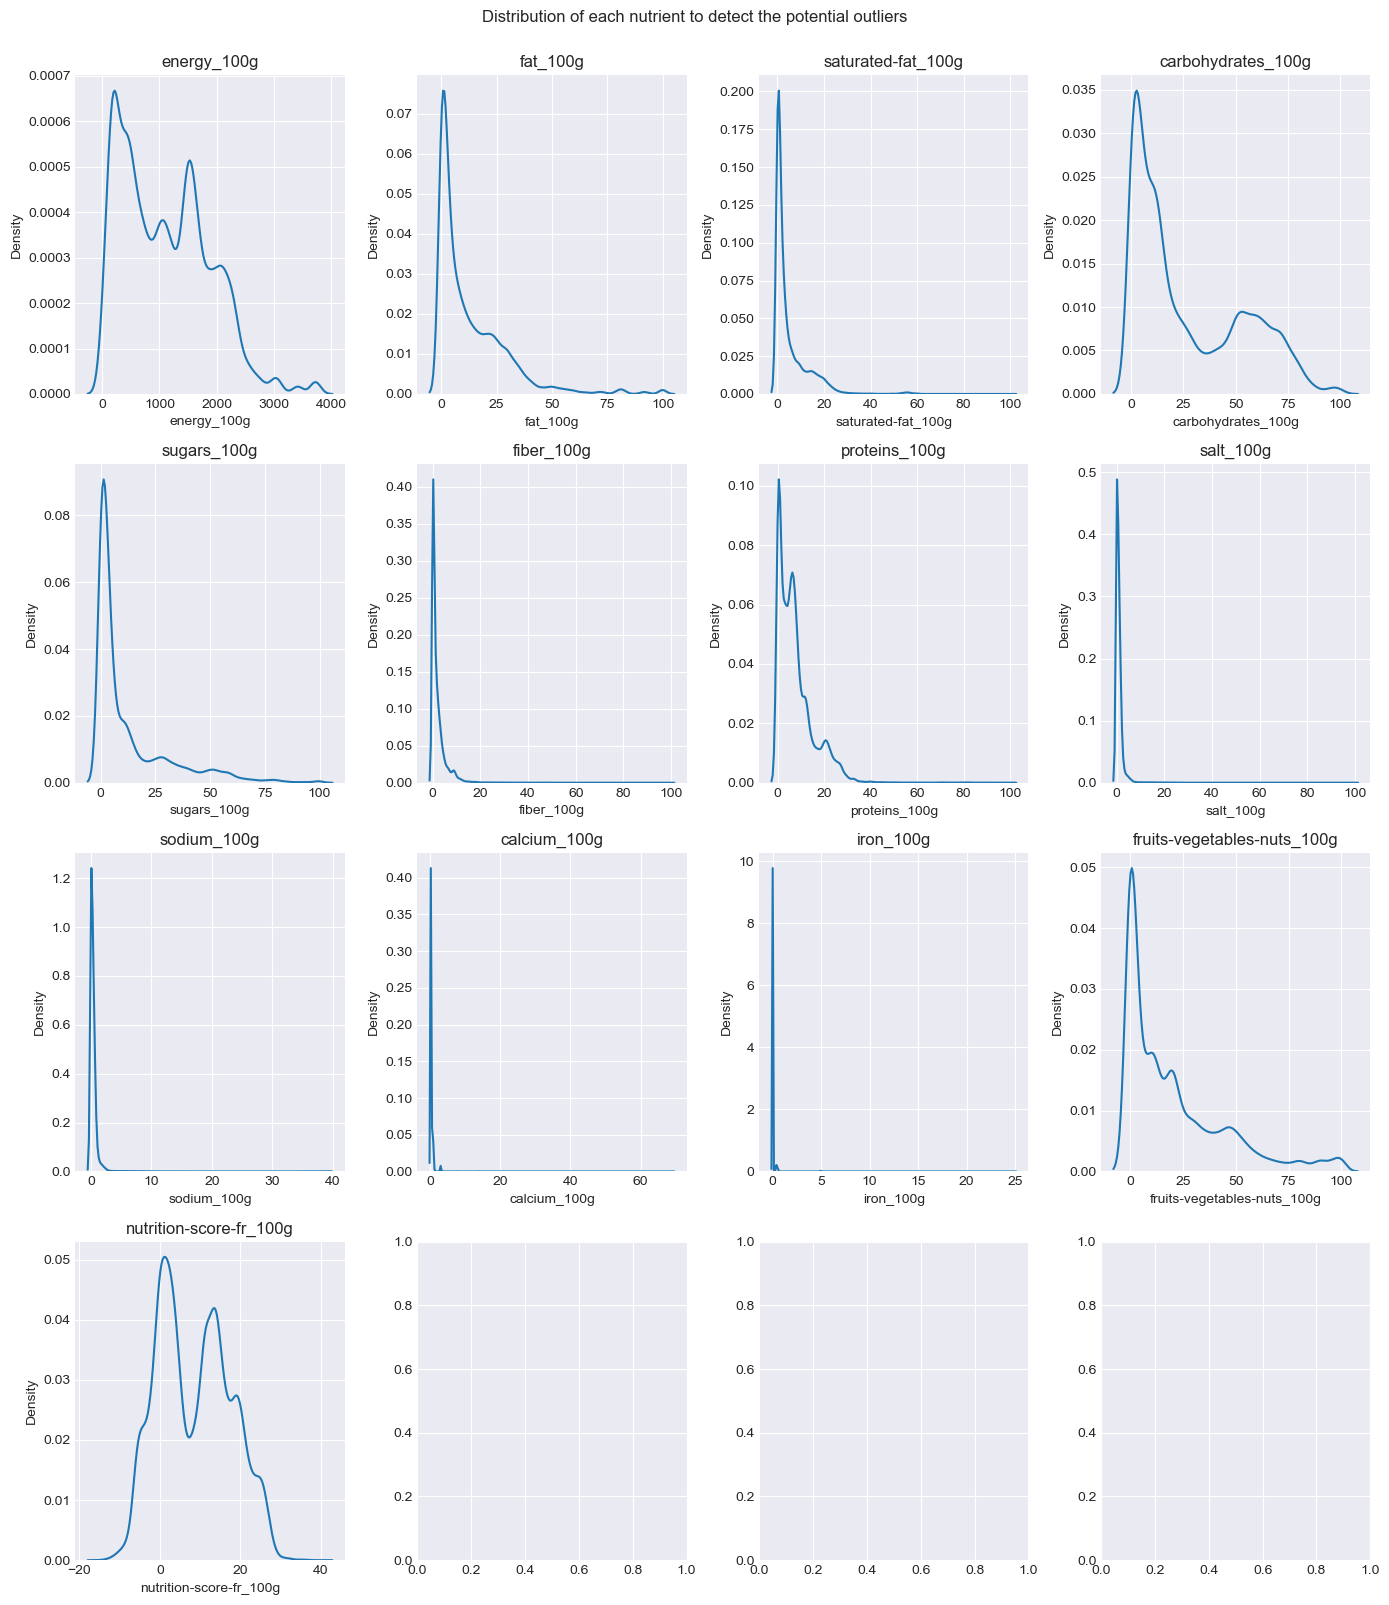

In [52]:
disp_outliers(off_data_f, plot='kdeplot')

Now that all the numerical features missing values are imputed. We can take care of the categorical features.

## Categorical features imputation

We start by substituting some categorical variables: If a product has no categories, we assign the category `Autres` to these missing values and we do the same for the name of the product, if it is missing, we assign the name `Non indiqué`. We do the same for the other categorical values.

In [53]:
off_data_f.categories_fr.fillna('Autres', inplace=True)
off_data_f.product_name.fillna('Non indiqué', inplace=True)
off_data_f.pnns_groups_1.fillna('unknown', inplace=True)
off_data_f.pnns_groups_2.fillna('unknown', inplace=True)
off_data_f.head()

,code,product_name,categories_fr,countries_fr,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,calcium_100g,iron_100g,fruits-vegetables-nuts_100g,nutrition-score-fr_100g
0,0000010187319,Mini Confettis,Autres,France,d,unknown,unknown,1753.0,1.00,0.8,23.14,23.14,0.9,0.6,0.0100,0.003937,0.036540,0.017441,14.00,14.0
1,0000010207260,Praliné Amande Et Noisette,Autres,France,d,unknown,unknown,2406.0,29.90,2.9,29.16,29.16,3.9,9.5,0.0030,0.001181,0.018270,0.002841,46.00,14.0
2,0000040608754,"Pepsi, Nouveau goût !","Boissons,Boissons gazeuses,Sodas,Sodas au cola...",France,e,Beverages,Sweetened beverages,177.0,0.00,0.0,10.40,10.40,0.0,0.0,0.0254,0.010000,0.167380,0.000030,22.38,13.0
3,0000069161025,Tarte Poireaux Et Lardons,Autres,France,d,unknown,unknown,1079.0,11.52,11.0,34.42,1.00,1.4,7.5,0.8000,0.314961,0.021080,0.013031,11.76,15.0
4,0000087177756,7Up,"Aliments et boissons à base de végétaux,Boisso...",France,e,Beverages,Sweetened beverages,177.0,0.00,0.0,10.40,10.40,0.0,0.0,0.1000,0.039370,0.038784,0.000030,22.38,13.0


In [54]:
off_data_f['nutrition-score-fr_100g'] = off_data_f['nutrition-score-fr_100g'].round().astype('int64')

In [55]:
off_data_f.drop([10071], axis=0, inplace=True)
off_data_f.reset_index(drop=True, inplace=True)

<a id='nutri_to_grade'></a>
We now take care of the imputation of the `nutrition_grade_fr` feature with the help of the `nutrition_score_en_100g` feature which allows us to associate a grade between A and E to each product.

In [56]:
# The rows you get back from iterrows are copies that are no longer connected to the original
# data frame, so edits don't change your dataframe. Thankfully, because each item you get back from
# iterrows contains the current index, you can use that to access and edit the relevant row of the dataframe
def nutri_to_grade(df) :
    """nutri_to_grade returns the input DataFrame df after imputing the nutrition_grade_fr's values.
    
    Parameters:
    df (DataFrame): a DataFrame
    
    Returns:
    DataFrame: Returns the initial DataFrame imputed.
    
    """
    for i, row in df.iterrows() :
        if ('Eau' in row.product_name):
            df['nutrition_grade_fr'][i] = 'a'
        elif (row['nutrition-score-fr_100g'] <= 1) & ('Boissons' in row.categories_fr):
            df['nutrition_grade_fr'][i] = 'b'
        elif (2 <= row['nutrition-score-fr_100g'] <= 5) & ('Boissons' in row.categories_fr):
            df['nutrition_grade_fr'][i] = 'c'
        elif (6 <= row['nutrition-score-fr_100g'] <= 9) & ('Boissons' in row.categories_fr):
            df['nutrition_grade_fr'][i] = 'd'
        elif (row['nutrition-score-fr_100g'] >= 10) & ('Boissons' in row.categories_fr):
            df['nutrition_grade_fr'][i] = 'e'
        elif (row['nutrition-score-fr_100g'] <= -1):
            df['nutrition_grade_fr'][i] = 'a'
        elif (0 <= row['nutrition-score-fr_100g'] <= 2):
            df['nutrition_grade_fr'][i] = 'b'
        elif (3 <= row['nutrition-score-fr_100g'] <= 10):
            df['nutrition_grade_fr'][i] = 'c'
        elif (11 <= row['nutrition-score-fr_100g'] <= 18):
            df['nutrition_grade_fr'][i] = 'd'
        elif (row['nutrition-score-fr_100g'] >= 19):
            df['nutrition_grade_fr'][i] = 'e'

In [57]:
nutri_to_grade(off_data_f)

In [58]:
off_data_f.isna().sum()

code                           0
product_name                   0
categories_fr                  0
countries_fr                   0
nutrition_grade_fr             0
pnns_groups_1                  0
pnns_groups_2                  0
energy_100g                    0
fat_100g                       0
saturated-fat_100g             0
carbohydrates_100g             0
sugars_100g                    0
fiber_100g                     0
proteins_100g                  0
salt_100g                      0
sodium_100g                    0
calcium_100g                   0
iron_100g                      0
fruits-vegetables-nuts_100g    0
nutrition-score-fr_100g        0
dtype: int64

A simple `.isna().sum()` lets us know that there is no missing values left.

In [59]:
off_data_f.head()

,code,product_name,categories_fr,countries_fr,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,calcium_100g,iron_100g,fruits-vegetables-nuts_100g,nutrition-score-fr_100g
0,0000010187319,Mini Confettis,Autres,France,d,unknown,unknown,1753.0,1.00,0.8,23.14,23.14,0.9,0.6,0.0100,0.003937,0.036540,0.017441,14.00,14
1,0000010207260,Praliné Amande Et Noisette,Autres,France,d,unknown,unknown,2406.0,29.90,2.9,29.16,29.16,3.9,9.5,0.0030,0.001181,0.018270,0.002841,46.00,14
2,0000040608754,"Pepsi, Nouveau goût !","Boissons,Boissons gazeuses,Sodas,Sodas au cola...",France,e,Beverages,Sweetened beverages,177.0,0.00,0.0,10.40,10.40,0.0,0.0,0.0254,0.010000,0.167380,0.000030,22.38,13
3,0000069161025,Tarte Poireaux Et Lardons,Autres,France,d,unknown,unknown,1079.0,11.52,11.0,34.42,1.00,1.4,7.5,0.8000,0.314961,0.021080,0.013031,11.76,15
4,0000087177756,7Up,"Aliments et boissons à base de végétaux,Boisso...",France,e,Beverages,Sweetened beverages,177.0,0.00,0.0,10.40,10.40,0.0,0.0,0.1000,0.039370,0.038784,0.000030,22.38,13


## Saving cleaned dataset to csv file

The last step is to save the cleaned dataset in a csv file.

In [60]:
off_data_f.to_csv('off_data_f.csv')